# Pair Trading - Cointegration

We would like to conduct the signal research on the cointegration trading strategy

## Background

Investment Universe : Cryptocurrency (ADA , BNB , BTC , ETH , XRP)

Research Period : 2018/06/01 - 2020/12/31

Pair Selection Frequency : 1 month

TPSL Level : 500 bps

# Trading Procedure

## Formation Period

### Target Algo Development

(1)Pair Selection

(2)Cointegration Coefficient

(3)ADF Test

## Trading Period

### (1) Determining Trading Threshold

For each value under the threshold set

Step 1 : Loop over the reseach period

Step 2 : Recording the PnL for Each Trade

Step 3 : Finding the Total Signal Count abd Total Average PnL

Using the non-parametric method mentioned in the document to search the threshold

### (2) Target Measure

(0)Date (Year & Month)

(1)Trading Pair

(2)ADF Test Value

(3)Spread Movement (Current & Previous Month)

(4)Threshold

(5)Total Trade Count (Current & Previous Month)

(6)Avg PnL (Current & Previous Month)

(7)SL Rate (Current & Previous Month)

In [26]:
import numpy as np
import pandas as pd
import scipy
import glob
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import statsmodels as sm

# Data Import

In [2]:
path = '/Users/ccm/Desktop/Trading/Algo/Data/Crypto/CCXT Data/Daily/*'

open_ = []
close = []
colname = []

for i , fname in enumerate(glob.glob(path)):
    
    data = pd.read_csv(fname)
    
    open_.append(data['Open'])
    close.append(data['Close'])
    colname.append(data['symbol'][0])
        
aggregated_df = pd.DataFrame(np.array(close) , columns = data['Timestamp'])
aggregated_df.index = colname
aggregated_df = aggregated_df.T
aggregated_df = aggregated_df.loc[:'2020-12-31']

aggregated_open_df = pd.DataFrame(np.array(open_) , columns = data['Timestamp'])
aggregated_open_df.index = colname
aggregated_open_df = aggregated_open_df.T
aggregated_open_df = aggregated_df.loc[:'2020-12-31']


In [3]:
aggregated_df

ADA/USDT  BTC/USDT  BNB/USDT  XRP/USDT  ETH/USDT
Timestamp                                                   
2018-06-01   0.22038   7521.01   14.2888   0.62151    579.00
2018-06-02   0.22648   7640.03   14.6732   0.64269    590.85
2018-06-03   0.22659   7714.26   14.6995   0.69010    619.66
2018-06-04   0.21243   7487.00   14.2636   0.65507    591.02
2018-06-05   0.21839   7625.00   15.6156   0.67464    609.05
...              ...       ...       ...       ...       ...
2020-12-27   0.15467  26281.66   33.6740   0.28407    685.11
2020-12-28   0.17627  27079.41   35.9510   0.24845    730.41
2020-12-29   0.19067  27385.00   39.0667   0.22142    732.00
2020-12-30   0.18389  28875.54   38.1558   0.21138    752.17
2020-12-31   0.18134  28923.63   37.3588   0.21959    736.42

[945 rows x 5 columns]

# Pair Selection

## Method 1 : Distance Measure by APT Model

In [4]:
# PCA Factor Model


def PCA_Factor_Model(X , colname , thres):
    
    mu = np.mean(X , 0)
    sigma = np.std(X , 0)
    
    Y = (X - mu)/sigma
    
    n = X.shape[1]
    
    PCA_model = PCA(n_components = n)
    PCA_model.fit(Y)
    PC_loading = PCA_model.components_
    PC_explained_ratio = PCA_model.explained_variance_ratio_
    
    for i in range(1 ,len( PC_explained_ratio)):
        
        if sum(PC_explained_ratio[:(i+1)]) > thres : 
            
            PC_loading = PC_loading[:(i+1) , :]
            break
        
    
    P = np.matmul(PC_loading,np.transpose(Y))
    
    factor_ret = np.matmul(np.diag(sigma) , np.matmul(np.transpose(PC_loading) , P))
    
    df = pd.DataFrame(factor_ret , index = [colname])
    df = df.T
    
    return df
    
    
# Pair Selection by Distance Measure

def Distance_Measure(factor_ret_arr , colname):
    
    closest_dist = -10000000
    selected_pair = []
    
    n = factor_ret_arr.shape[1]
    
    for i in range(n-1):
        
        first_asset_factor_ret = factor_ret_arr[: , i]
        
        for j in range(i+1 , n):
            
            second_asset_factor_ret = factor_ret_arr[: , j]
            
            Var_Cov = np.cov(first_asset_factor_ret , second_asset_factor_ret)
            
            distance = abs(Var_Cov[1,0]/np.sqrt((Var_Cov[0,0] * Var_Cov[1,1])))
            
            if distance > closest_dist:
                
                closest_dist = distance
                
                selected_pair = [colname[i] , colname[j]]
                
    return selected_pair , closest_dist

## Method 2 : ADF Test          

In [5]:
def ADF_Measure(sample_data_df):
    
    n = len(sample_data_df.columns)
    best_ADF_test_value = 100000
    selected_first_asset = None
    selected_second_asset = None
    selected_beta_1 = None
    selected_beta_0 = None
    
    for i in range(n-1):
        
        first_asset = sample_data_df.columns[i]
        
        for j in range(i+1 , n):
            
            second_asset = sample_data_df.columns[j]
            
            test_sample_data = sample_data_df[[first_asset , second_asset]]
            
            sign = np.sign(np.cov(test_sample_data)[1,0])
            beta_0 , beta_1 , first_asset , second_asset = cointegration_coefficient_TLS(np.array(test_sample_data) , sign ,[first_asset , second_asset])
        
            spread = (test_sample_data[first_asset] - beta_0 - beta_1*test_sample_data[second_asset])/np.sqrt(1+beta_1**2)
        
            best_lag_order = spread_lag_order(spread , 0 , 10)
        
            test_value = ADF_test(spread , best_lag_order)
            
            if test_value < best_ADF_test_value:
                
                best_ADF_test_value = test_value
                
                selected_first_asset = first_asset
                selected_second_asset = second_asset
                selected_beta_1 = beta_1
                selected_beta_0 = beta_0
                
    return selected_beta_0 , selected_beta_1 , selected_first_asset , selected_second_asset , best_ADF_test_value
            
            
    

# Cointegration Coefficient

## Method 1 : Correlation of the Factor Return

(Idea based on Common trend & APT Model)

In [6]:
def cointegration_coefficient_factor_corr(factor_ret_arr , colname):
    
    var_cov_mat = np.cov(factor_ret_arr)
    
    if (var_cov_mat[0,0] > var_cov_mat[1,1]):
        
        first_asset = colname[0]
        second_asset = colname[1]
        coef = var_cov_mat[1,0] / var_cov_mat[1,1]
    
    else :
        
        first_asset = colname[1]
        second_asset = colname[0]
        coef = var_cov_mat[1,0] / var_cov_mat[0,0]
        
    return coef , first_asset , second_asset
    

## Method 2 : Regression (TLS)

In [7]:
def cointegration_coefficient_TLS(scaled_log_price , sign ,colname):
    
    beta_1 = []
    beta_0 = []
    
    X = scaled_log_price[:,0]
    Y = scaled_log_price[:,1]
    
    C_0 = sum((X - np.mean(X))*(Y - np.mean(Y)))
    C_1 = sum((X - np.mean(X))**2 - (Y - np.mean(Y))**2)
    C_2 = -1*C_0
    
    beta_1.append((-1 * C_1 + sign * np.sqrt(C_1**2-4*C_0*C_2))/(2 * C_0))
    beta_0.append(np.mean(Y)-beta_1[-1]*np.mean(X))
    
    X = scaled_log_price[:,1]
    Y = scaled_log_price[:,0]
    
    C_0 = sum((X - np.mean(X))*(Y - np.mean(Y)))
    C_1 = sum((X - np.mean(X))**2 - (Y - np.mean(Y))**2)
    C_2 = -1*C_0
    
    beta_1.append((-1 * C_1 + sign * np.sqrt(C_1**2-4*C_0*C_2))/(2 * C_0))
    beta_0.append(np.mean(Y)-beta_1[-1]*np.mean(X))
    
    if (beta_1[0] > beta_1[1]):
        
        first_asset = colname[1]
        second_asset = colname[0]
        
        return beta_0[0] , beta_1[0] , first_asset , second_asset
    
    else :
        
        first_asset = colname[0]
        second_asset = colname[1]
        
        return beta_0[1] , beta_1[1] , first_asset , second_asset
    

# ADF Test

In [8]:
# Finding the correct lag_order

def spread_lag_order(spread , min_lag , max_lag):
    
    spread_diff = np.array(spread[1:]) - np.array(spread[:-1])
    
    best_bic = 100000
    best_lag_order = None
    
    for p in range(min_lag , max_lag+1):
        
        Y = []
        X = []
        
        if p == 0 : 
            
            Y = spread_diff
            X = spread[:-1]
            
        else :
            
            for i in range(p , len(spread_diff)):
                
                Y.append(spread_diff[i-1])
                X.append(np.append(np.array(spread[i-1]) , spread_diff[(i-p):(i-1)][::-1]))
            
        OLS_model = sm.api.OLS(Y , X)
        res = OLS_model.fit()
        
        if (res.info_criteria('bic') < best_bic):
            
            best_bic = res.info_criteria('bic')
            best_lag_order = p
            
    return best_lag_order

# Using the ADF test to confirm the stationarity of the spread

def ADF_test(spread , lag_order):
    
    spread_diff = np.array(spread[1:]) - np.array(spread[:-1])
    
    Y = []
    X = []
    
    
    if lag_order == 0 : 
        
        Y = spread_diff
        X = spread[:-1]
            
    else :
            
        for i in range(lag_order , len(spread_diff)):
                
            Y.append(spread_diff[i-1])
            X.append(np.append(np.array(spread[i-1]) , spread_diff[(i-lag_order):(i-1)][::-1]))
            
    OLS_model = sm.api.OLS(Y , X)
    res = OLS_model.fit()
    
    return res.tvalues[0]


# Threshold selection

In [212]:
def regularization_cost(regularized_value, trade_off_rate, Target_value):
    
    accuracy_cost = sum((Target_value - regularized_value) ** 2)
    smoonthness_cost = sum((regularized_value[1:] - regularized_value[:-1])**2)
    
    return accuracy_cost + trade_off_rate * smoonthness_cost
    

def threshold_optimization(threshold_set , Total_count , Avg_PnL):
    
    trade_off_rate_set = np.array(range(-12,13))
    Total_count_reg_cost = []
    Avg_PnL_reg_cost = []
    
    for trade_off_rate in trade_off_rate_set:
        
        Total_count_res = scipy.optimize.minimize(regularization_cost , np.zeros(len(Total_count)) , args = (np.exp(trade_off_rate) ,Total_count))
        Avg_PnL_res = scipy.optimize.minimize(regularization_cost , np.zeros(len(Avg_PnL)) , args = (np.exp(trade_off_rate) ,Avg_PnL))
        
        Total_count_cost = regularization_cost(Total_count_res.x, np.exp(trade_off_rate), Total_count)
        Avg_PnL_cost = regularization_cost(Avg_PnL_res.x, np.exp(trade_off_rate), Avg_PnL)
        
        Total_count_reg_cost.append(Total_count_cost)
        Avg_PnL_reg_cost.append(Avg_PnL_cost)
        
    Total_count_distance = 10000
    Total_count_mean = np.mean(Total_count_reg_cost)
    Total_count_target = -1
    
    Avg_PnL_distance = 10000
    Avg_PnL_mean = np.mean(Avg_PnL_reg_cost)
    Avg_PnL_target = -1

    for i in range(len(Avg_PnL_reg_cost)):
        
        if abs(Total_count_reg_cost[i] - Total_count_mean) < Total_count_distance : 
            
            Total_count_distance = abs(Total_count_reg_cost[i] - Total_count_mean)
        
            Total_count_target = i
        
        if abs(Avg_PnL_reg_cost[i] - Avg_PnL_mean) < Avg_PnL_distance : 
        
            Avg_PnL_distance = abs(Avg_PnL_reg_cost[i] - Avg_PnL_mean)
        
            Avg_PnL_target = i
            
    
    Total_count_best_trade_off_rate = trade_off_rate_set[Total_count_target]
    Avg_PnL_best_trade_off_rate = trade_off_rate_set[Avg_PnL_target]
    
    Total_count_optimal_res = scipy.optimize.minimize(regularization_cost , np.zeros(len(Total_count)) , args = (np.exp(Total_count_best_trade_off_rate) ,Total_count))
    Avg_PnL_optimal_res = scipy.optimize.minimize(regularization_cost , np.zeros(len(Total_count)) , args = (np.exp(Avg_PnL_best_trade_off_rate) ,Avg_PnL))
    
    plt.plot(Total_count_optimal_res.x , color = 'b')
    plt.plot(Total_count, color = 'r')
    plt.title('total count')
    plt.show()
    
    plt.plot(Avg_PnL_optimal_res.x , color = 'b')
    plt.plot(Avg_PnL, color = 'r')
    plt.title('Avg PnL')
    plt.show()
    
    smoothed_Total_PnL = Total_count_optimal_res.x * Avg_PnL_optimal_res.x
    
    plt.plot(smoothed_Total_PnL)
    plt.show()
        
    selected_threshold = threshold_set[np.where(smoothed_Total_PnL == max(smoothed_Total_PnL))[0][0]]
    
    return(selected_threshold)

# Signal Performance Analysis

In [276]:
def signal_performance_analysis(scaled_sample_data_close_price_df, sample_data_open_price_df ,sample_data_close_price_df ,selected_asset ,coefficient , spread_volatility , threshold , SL_rate):
    
    trading_flag = 0
    trading_signal_hit_rate = 0
    trading_period = 0
    aggregate_trading_info = []
    
    for day in range(len(sample_data_open_price_df)-1):
        
        current_close_price = sample_data_close_price_df.iloc[day]
        scaled_current_close_price = scaled_sample_data_close_price_df.iloc[day]
        next_open_price = sample_data_open_price_df.iloc[day+1]
        
        current_spread_noise = (scaled_current_close_price[selected_asset[0]] - coefficient[0] - coefficient[1] * scaled_current_close_price[selected_asset[1]])/np.sqrt(1+coefficient[1]**2)
        
        current_std_spread_noise = current_spread_noise/spread_volatility
        
        if trading_flag == 0 : 
            
            if trading_signal_hit_rate >= 1 : 
                
                if aggregate_trading_info[-1][1] == '1' and current_std_spread_noise <= 0 : 
                    
                    trading_signal_hit_rate = 0
                    
                elif aggregate_trading_info[-1][1] == '-1' and current_std_spread_noise >= 0 :
                    
                    trading_signal_hit_rate = 0
                    
                else : 
                    
                    continue
            
            if abs(current_std_spread_noise) < threshold : 
                continue
                
            elif current_std_spread_noise>threshold:
                
                trading_flag = 1
                trading_period = 1
                trade_date = next_open_price.name
                long_asset = selected_asset[1]
                short_asset = selected_asset[0]
                long_cost = next_open_price[long_asset]
                short_cost = next_open_price[short_asset]
                
                current_trade_info = np.array([trade_date, trading_flag , long_asset , short_asset , long_cost , short_cost])
                      
            else:
                
                trading_flag = -1
                trading_period = 1
                trade_date = next_open_price.name
                long_asset = selected_asset[0]
                short_asset = selected_asset[1]
                long_cost = next_open_price[long_asset]
                short_cost = next_open_price[short_asset]
                
                current_trade_info = np.array([trade_date , trading_flag ,long_asset , short_asset , long_cost , short_cost])
                
            trading_signal_hit_rate = 1
                
        else : 
            
            if trading_flag ==  1 :
                
                trade_PnL = (coefficient[1]/(1+coefficient[1])) * (current_close_price[long_asset] - long_cost)/long_cost - (1/(1+coefficient[1])) * (current_close_price[short_asset] - short_cost)/short_cost
                
                if trade_PnL > SL_rate and current_std_spread_noise > 0 and day != len(sample_data_open_price_df)-2 :
                    trading_period += 1
                    continue
                    
                elif current_std_spread_noise <= 0 :
                    
                    trading_flag = 0
                    trading_signal_hit_rate = 0
                    close_date = current_close_price.name
                    long_close = next_open_price[long_asset]
                    short_close = next_open_price[short_asset]
                    PnL = (coefficient[1]/(1+coefficient[1])) * (long_close - long_cost)/long_cost - (1/(1+coefficient[1])) * (short_close - short_cost)/short_cost
                    coverage = 'Y'
                    
                    current_trade_info = np.append(current_trade_info , np.array([close_date , long_close ,short_close , trading_period , PnL , coverage]))
                    
                    trading_period = 0
                    
                else :
                    
                    trading_flag = 0
                    close_date = current_close_price.name
                    long_close = next_open_price[long_asset]
                    short_close = next_open_price[short_asset]
                    PnL = (coefficient[1]/(1+coefficient[1])) * (long_close - long_cost)/long_cost - (1/(1+coefficient[1])) * (short_close - short_cost)/short_cost
                    if trade_PnL < SL_rate:
                        coverage = 'SL'
                    else :
                        coverage = 'N'
                        
                    current_trade_info = np.append(current_trade_info , np.array([close_date , long_close ,short_close , trading_period , PnL , coverage]))
                    
                    trading_period = 0
                        
            else :
                
                trade_PnL = (1/(1+coefficient[1])) * (current_close_price[long_asset] - long_cost)/long_cost - (coefficient[1]/(1+coefficient[1])) * (current_close_price[short_asset] - short_cost)/short_cost
                
                if trade_PnL > SL_rate and current_std_spread_noise < 0 and day != len(sample_data_open_price_df)-2 :
                    trading_period += 1
                    continue
                    
                elif current_std_spread_noise >= 0 :
                    
                    trading_flag = 0
                    trading_signal_hit_rate = 0
                    close_date = current_close_price.name
                    long_close = next_open_price[long_asset]
                    short_close = next_open_price[short_asset]
                    PnL = (1/(1+coefficient[1])) * (long_close - long_cost)/long_cost - (coefficient[1]/(1+coefficient[1])) * (short_close - short_cost)/short_cost
                    coverage = 'Y'
                    
                    current_trade_info = np.append(current_trade_info , np.array([close_date , long_close ,short_close , trading_period , PnL , coverage]))
                    
                    trading_period = 0
                    
                else :
                    
                    trading_flag = 0
                    close_date = current_close_price.name
                    long_close = next_open_price[long_asset]
                    short_close = next_open_price[short_asset]
                    PnL = (1/(1+coefficient[1])) * (long_close - long_cost)/long_cost - (coefficient[1]/(1+coefficient[1])) * (short_close - short_cost)/short_cost
                    if trade_PnL < SL_rate:
                        coverage = 'SL'
                    else :
                        coverage = 'N'
                        
                    current_trade_info = np.append(current_trade_info , np.array([close_date , long_close ,short_close , trading_period , PnL , coverage]))
                    
                    trading_period = 0
                        
            aggregate_trading_info.append(current_trade_info)
            
    aggregate_trading_info_df_columns = ['trade date' , 'trading_signal' , 'long asset' , 'short asset' , 'long cost' , 'short cost' , 'close date' , 'long close' , 'short close' , 'trading period' , 'PnL' , 'coverage' ]
            
    if len(aggregate_trading_info) == 0 : 
        
        aggregate_trading_info_df = pd.DataFrame([0 for i in range(len(aggregate_trading_info_df_columns))])
        aggregate_trading_info_df = aggregate_trading_info_df.T
        
    else :
        
        aggregate_trading_info_df = pd.DataFrame(aggregate_trading_info)
    
    aggregate_trading_info_df.columns = aggregate_trading_info_df_columns

    return aggregate_trading_info_df

# Testing

## Part (1) Pair Selection Method

### Plot the spread formed by APT Model (Pair Selection : Distance Measure by APT)

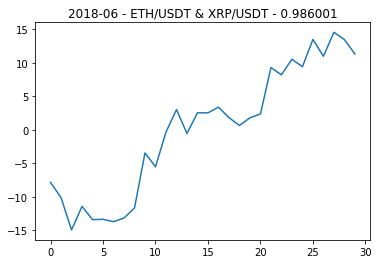

test value : 0.028277


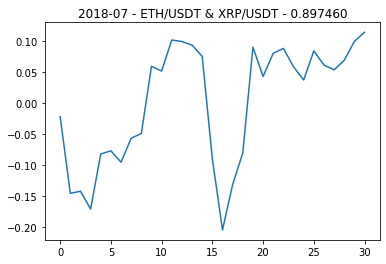

test value : -1.751985


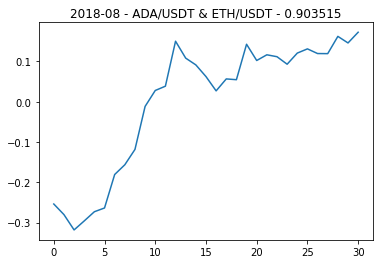

test value : -1.202524


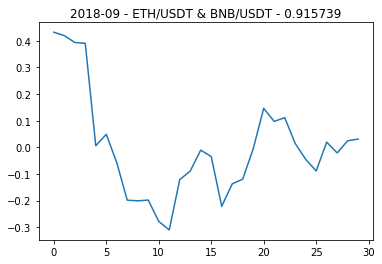

test value : -2.484644


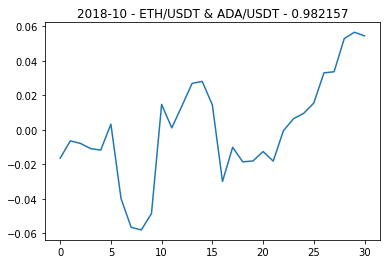

test value : -1.407891


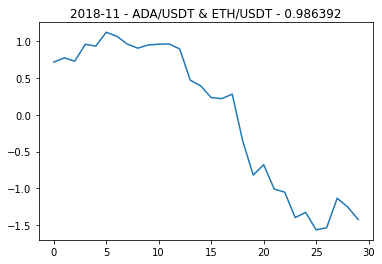

test value : 0.017134


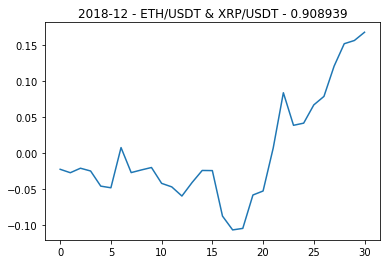

test value : -0.017320


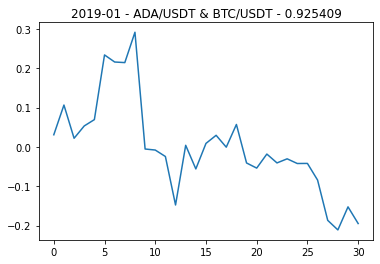

test value : -1.716654


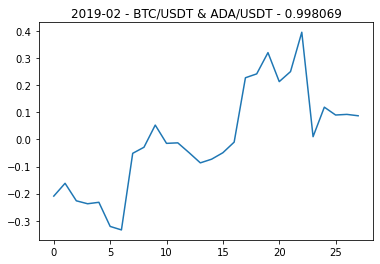

test value : -1.826377


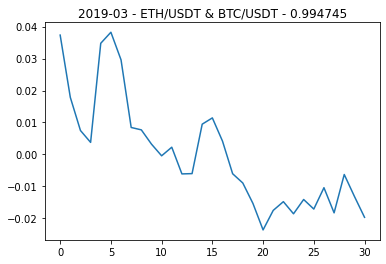

test value : -2.307688


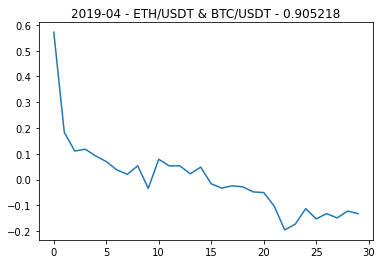

test value : -1.542186


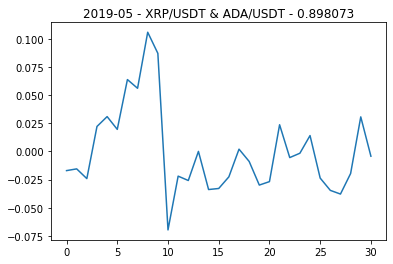

test value : -3.220439


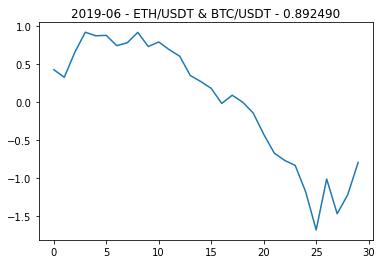

test value : -0.183225


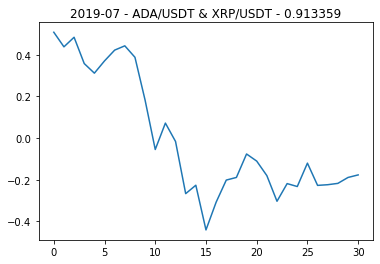

test value : -1.736656


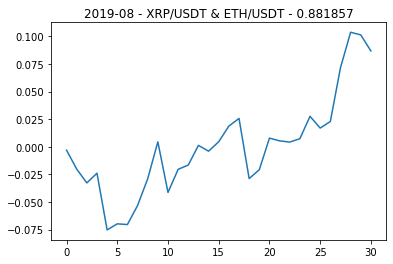

test value : -0.818925


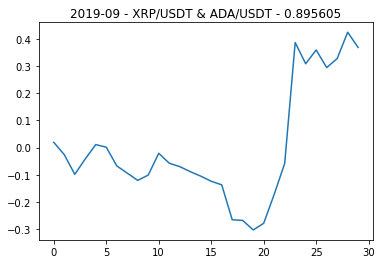

test value : -0.718446


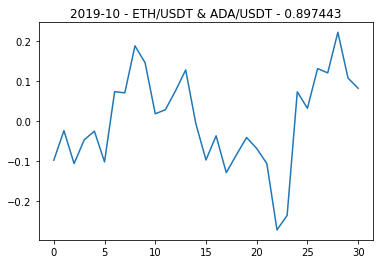

test value : -2.566359


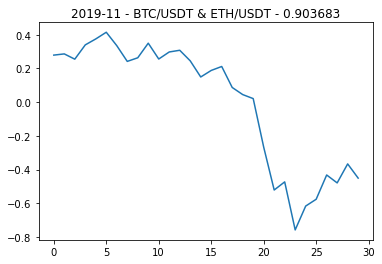

test value : -0.550091


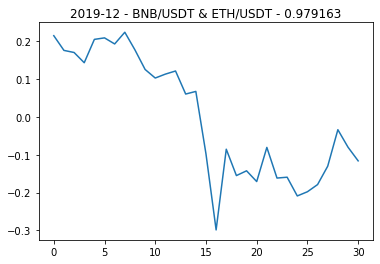

test value : -1.564451


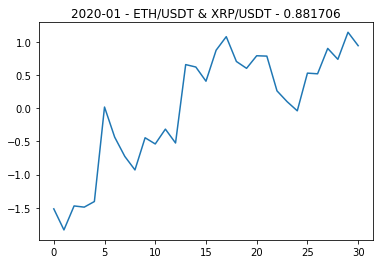

test value : -0.365193


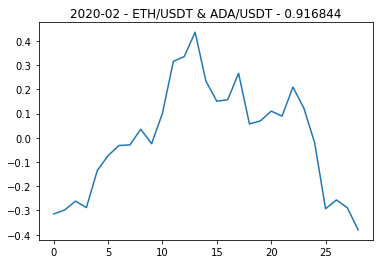

test value : -1.200905


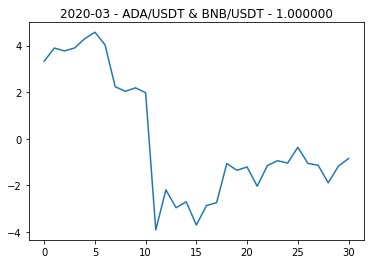

test value : -2.464417


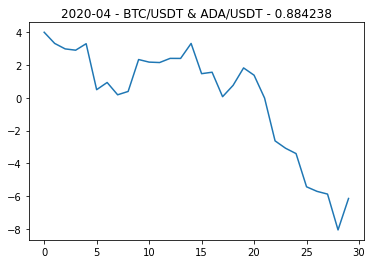

test value : -0.566673


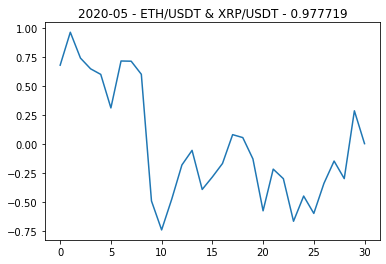

test value : -2.190515


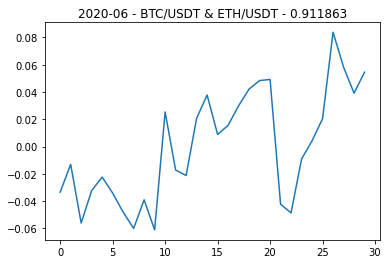

test value : -2.292876


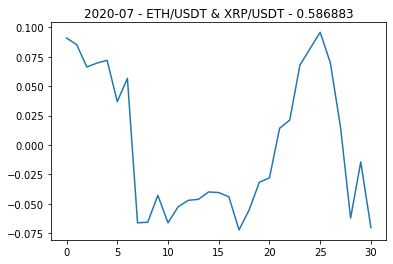

test value : -1.929919


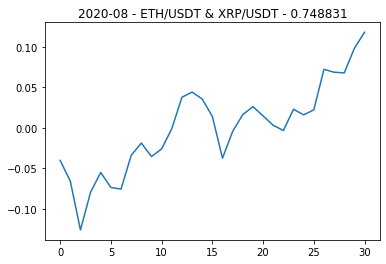

test value : -0.612999


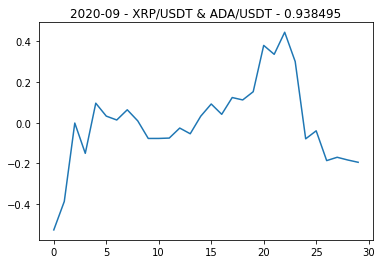

test value : -2.942366


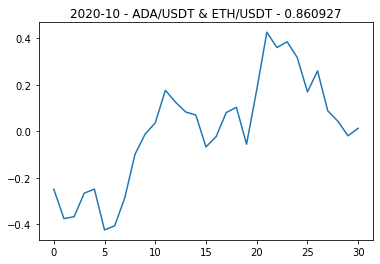

test value : -1.561936


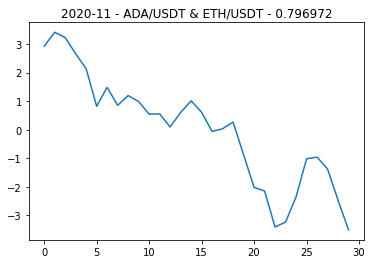

test value : -1.613115


In [29]:
sample_data = []
sample_month = -1

for i in range (len(aggregated_df)-1) : 
    
    if len(sample_data) == 0:
        
        sample_month = datetime.datetime.strptime(aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data.append(np.array(aggregated_df.iloc[i]))
    
    next_data_month = datetime.datetime.strptime(aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month :
        
        sample_data_df = pd.DataFrame(np.array(sample_data) , columns = aggregated_df.columns)
        
        sample_data = []
        
        log_sample = np.log(sample_data_df)
        
        log_ret = np.array(log_sample.diff().dropna())
        colname = aggregated_df.columns
        thres = 0.99
        
        factor_ret = PCA_Factor_Model(log_ret , colname , thres)
        selected_pair , distance = Distance_Measure(np.array(factor_ret) , colname)
        selected_factor_ret = factor_ret[selected_pair]
        
        coef , first_asset , second_asset = cointegration_coefficient_factor_corr(np.array(selected_factor_ret) , selected_pair)
        
        spread = log_sample[first_asset] - coef * log_sample[second_asset]
        mean = np.mean(spread)
        spread = spread - mean
        
        plt.title('%s - %s & %s - %f' % ((aggregated_df.index[i][:-3] ,first_asset ,second_asset ,distance )))
        plt.plot(spread)
        plt.show()
        
        best_lag_order = spread_lag_order(spread , 0 , 10)
        
        test_value = ADF_test(spread , best_lag_order)
        
        print('test value : %f' %test_value)
        
        
        

### Plot the Spread formed by TLS (Pair Selection : Distance Measure by APT)

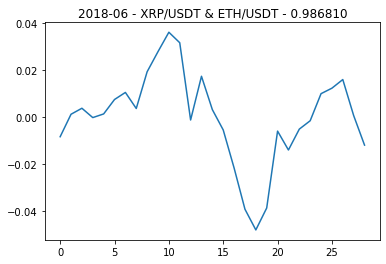

test value : -1.826733


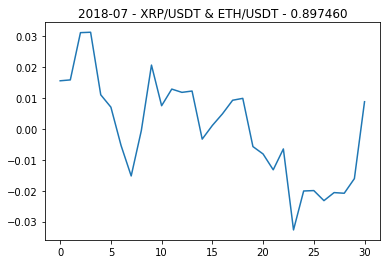

test value : -2.122876


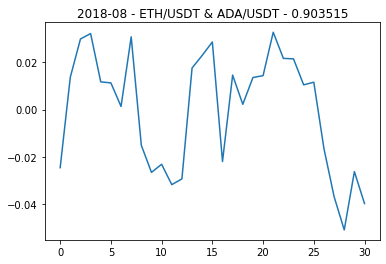

test value : -2.573482


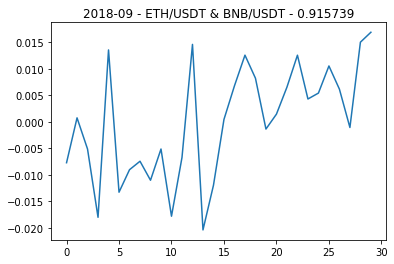

test value : -3.994684


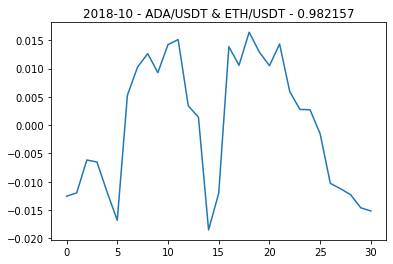

test value : -2.096724


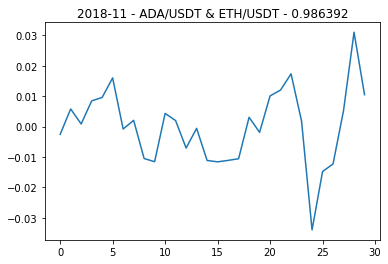

test value : -3.173616


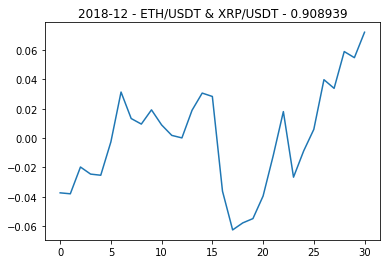

test value : -1.387113


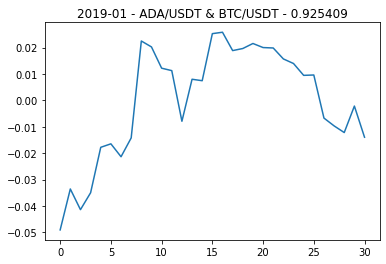

test value : -2.500508


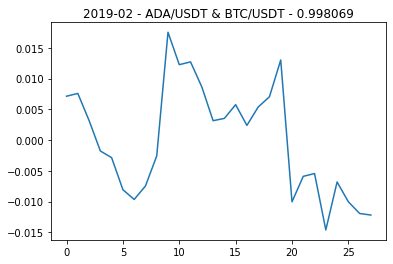

test value : -2.093325


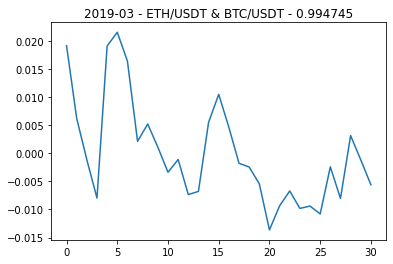

test value : -3.164616


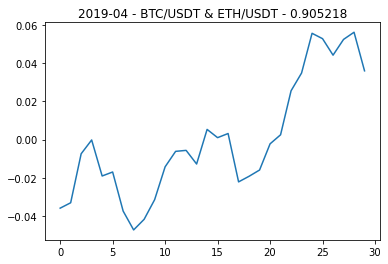

test value : -1.170991


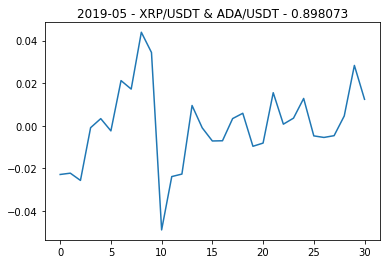

test value : -3.742399


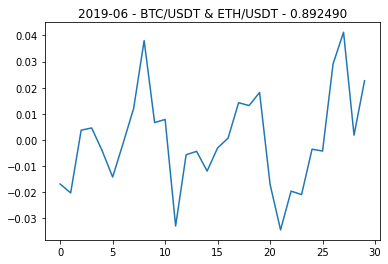

test value : -3.242345


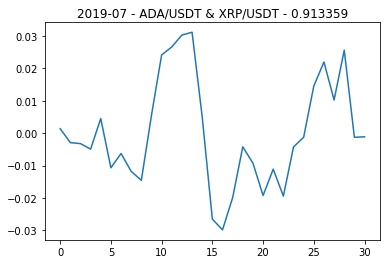

test value : -2.304530


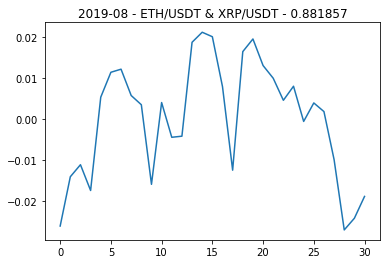

test value : -2.784975


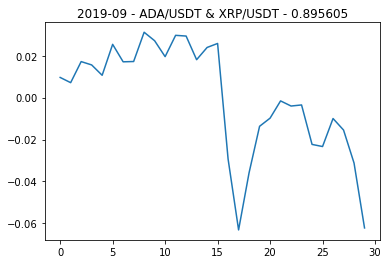

test value : -1.041933


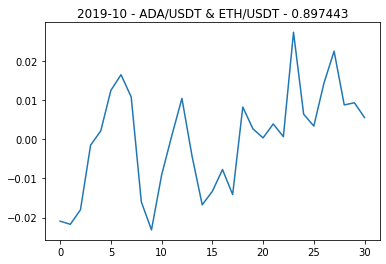

test value : -3.014687


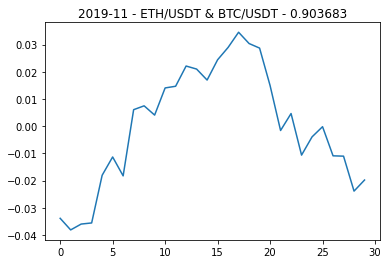

test value : -1.545688


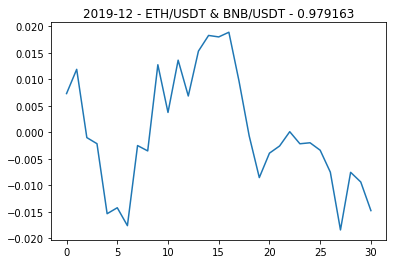

test value : -1.860586


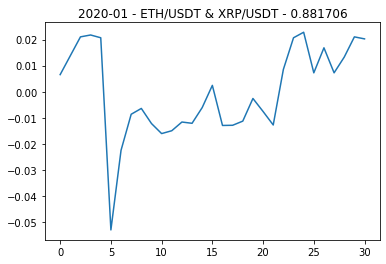

test value : -2.854146


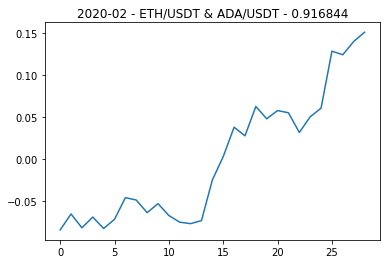

test value : 0.081377


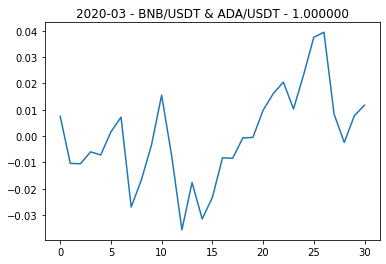

test value : -2.358530


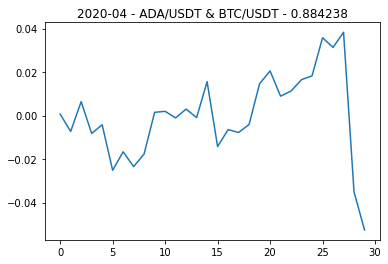

test value : -2.042651


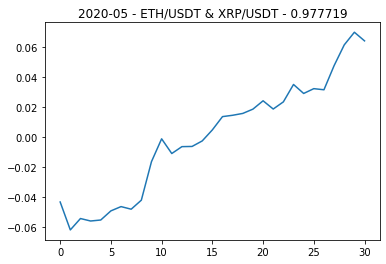

test value : -0.071337


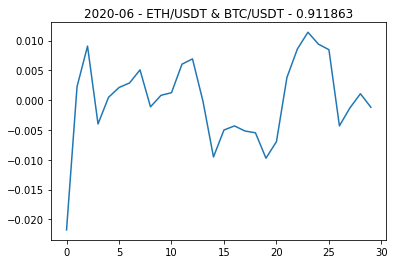

test value : -4.656072


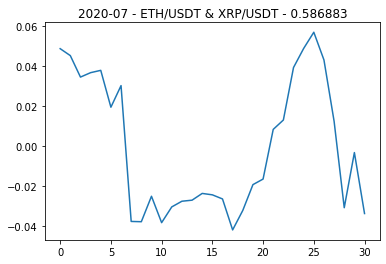

test value : -1.931824


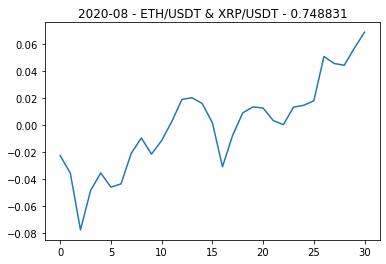

test value : -0.699207


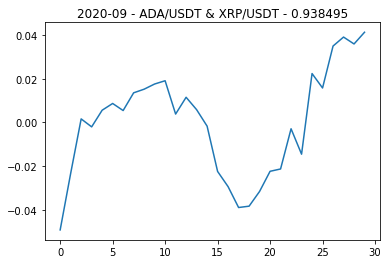

test value : -1.778857


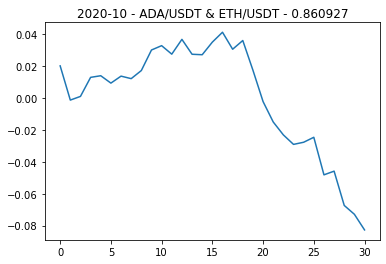

test value : 0.803477


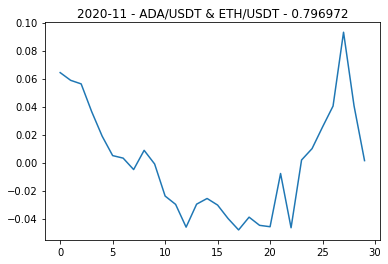

test value : -2.176319


In [44]:
sample_data = []
sample_month = -1

# Scaling the data

scaled_aggregated_df = np.log(aggregated_df[1:]) - np.log(aggregated_df.iloc[0])

for i in range (len(scaled_aggregated_df)-1) : 
    
    if len(sample_data) == 0:
        
        sample_month = datetime.datetime.strptime(scaled_aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data.append(np.array(scaled_aggregated_df.iloc[i]))
    
    next_data_month = datetime.datetime.strptime(scaled_aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month :
        
        sample_data_df = pd.DataFrame(np.array(sample_data) , columns = scaled_aggregated_df.columns)
        
        sample_data = []
        
        log_sample = sample_data_df
        
        log_ret = np.array(log_sample.diff().dropna())
        colname = scaled_aggregated_df.columns
        thres = 0.99
        
        factor_ret = PCA_Factor_Model(log_ret , colname , thres)
        selected_pair , distance = Distance_Measure(np.array(factor_ret) , colname)
        
        selected_sample = sample_data_df[selected_pair]
        sign = np.sign(np.cov(selected_sample)[1,0])
        beta_0 , beta_1 , first_asset , second_asset = cointegration_coefficient_TLS(np.array(selected_sample) , sign ,selected_pair)
        
        spread = (selected_sample[first_asset] - beta_0 - beta_1*selected_sample[second_asset])/np.sqrt(1+beta_1**2)
        
        plt.title('%s - %s & %s - %f' % ((scaled_aggregated_df.index[i][:-3] ,first_asset ,second_asset ,distance )))
        plt.plot(spread)
        plt.show()
        
        best_lag_order = spread_lag_order(spread , 0 , 10)
        
        test_value = ADF_test(spread , best_lag_order)
        
        print('test value : %f' %test_value)

### Plot the Spread formed by TLS (Pair Selection : ADF test value)

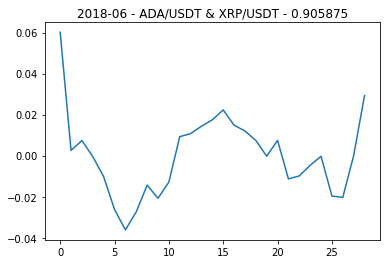

test value : -3.710497


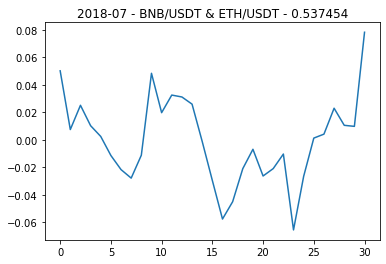

test value : -2.935078


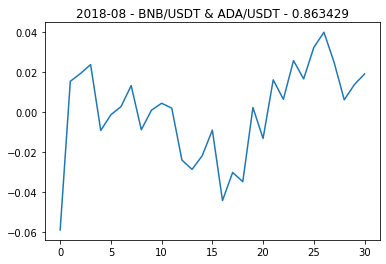

test value : -3.734003


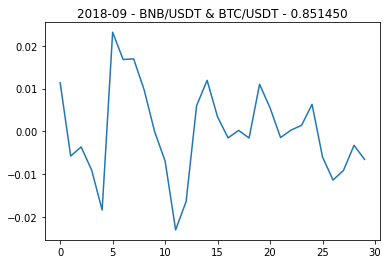

test value : -3.488428


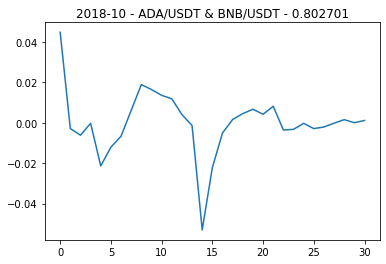

test value : -4.541620


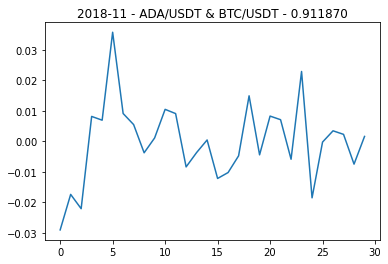

test value : -4.892775


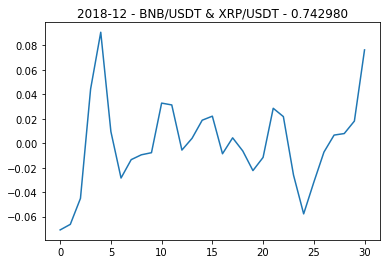

test value : -6.232156


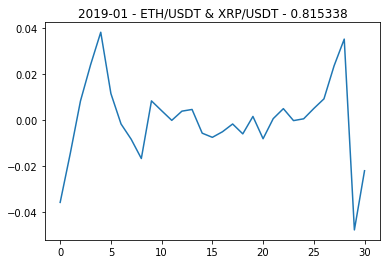

test value : -4.209101


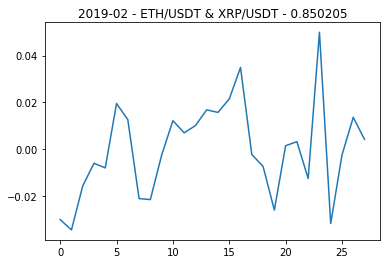

test value : -4.580209


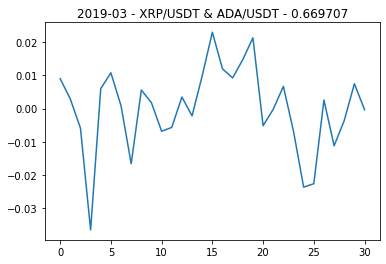

test value : -3.981166


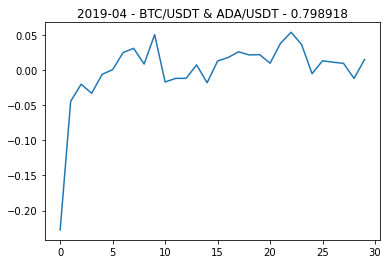

test value : -9.152547


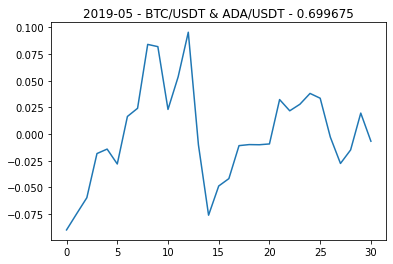

test value : -2.870233


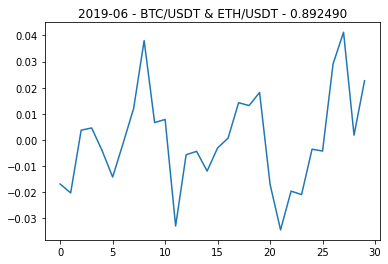

test value : -3.242345


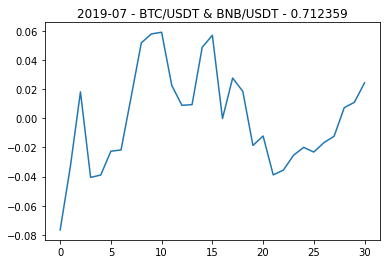

test value : -3.046733


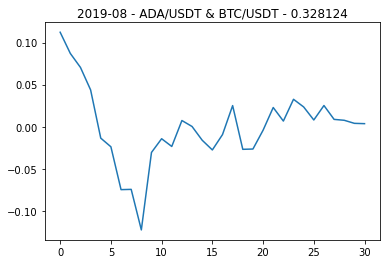

test value : -2.989559


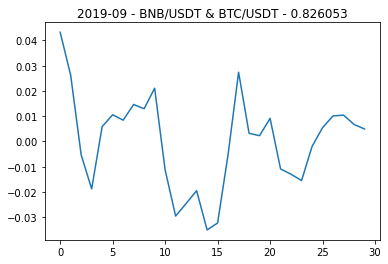

test value : -3.312250


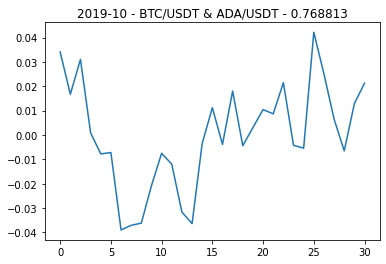

test value : -2.840032


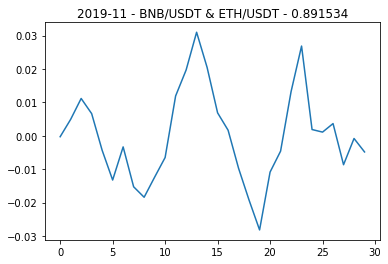

test value : -2.265084


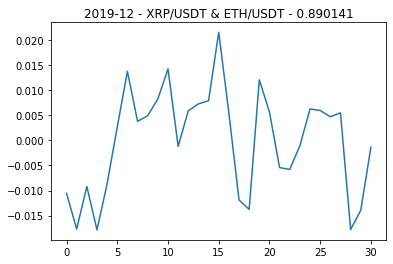

test value : -3.302783


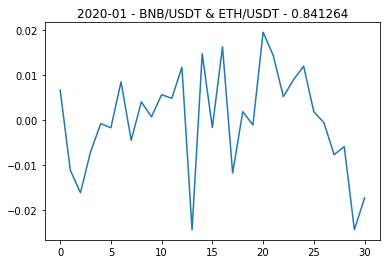

test value : -4.562516


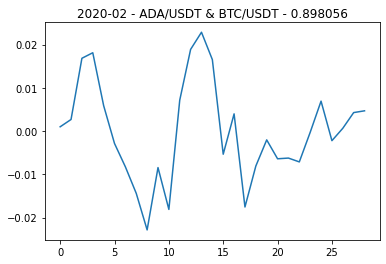

test value : -2.646972


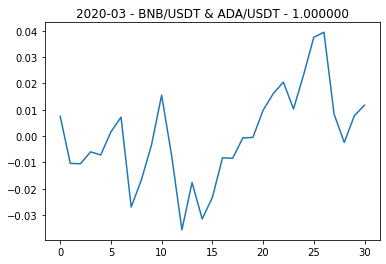

test value : -2.358530


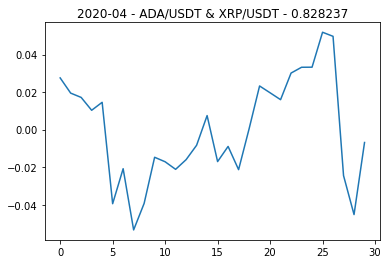

test value : -2.549999


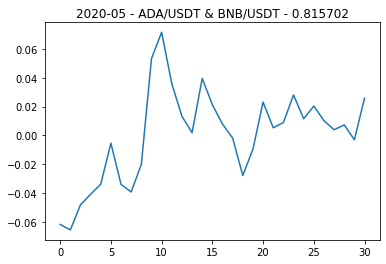

test value : -2.587344


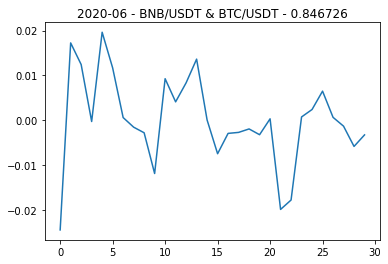

test value : -4.912920


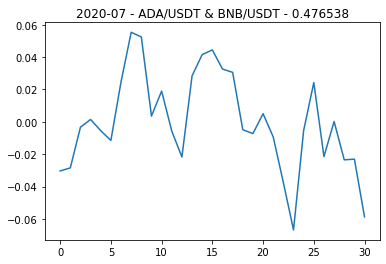

test value : -2.492961


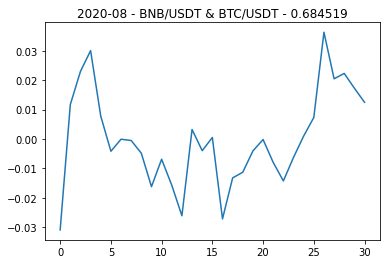

test value : -3.185735


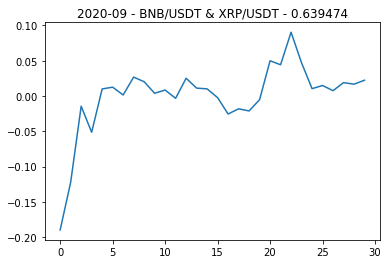

test value : -5.121468


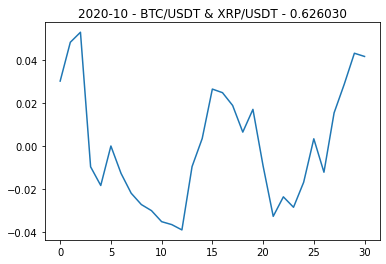

test value : -1.821612


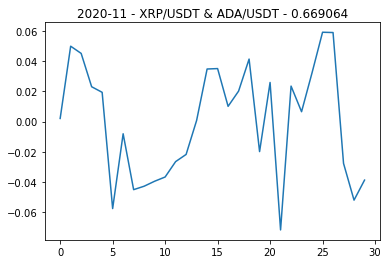

test value : -3.428598


In [60]:
scaled_sample_data = []
sample_data = []
sample_month = -1

# Scaling the data

scaled_aggregated_df = np.log(aggregated_df) - np.log(aggregated_df.iloc[0])

for i in range (1 , len(scaled_aggregated_df)-1) : 
    
    if len(scaled_sample_data) == 0:
        
        sample_month = datetime.datetime.strptime(scaled_aggregated_df.index[i] , '%Y-%m-%d').month
        
    scaled_sample_data.append(np.array(scaled_aggregated_df.iloc[i]))
    sample_data.append(np.array(aggregated_df.iloc[i]))
    
    next_data_month = datetime.datetime.strptime(scaled_aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month :
        
        scaled_sample_data_df = pd.DataFrame(np.array(scaled_sample_data) , columns = scaled_aggregated_df.columns)
        sample_data_df = pd.DataFrame(np.array(sample_data) , columns = aggregated_df.columns)
        
        scaled_sample_data = []
        sample_data = []
        
        beta_0 , beta_1 , first_asset , second_asset , test_value = ADF_Measure(scaled_sample_data_df)
        
        spread = (scaled_sample_data_df[first_asset] - beta_0 - beta_1*scaled_sample_data_df[second_asset])/np.sqrt(1+beta_1**2)
        
        log_sample = np.log(sample_data_df)
        log_ret = np.array(log_sample.diff().dropna())
        colname = aggregated_df.columns
        thres = 0.99
        factor_ret = PCA_Factor_Model(log_ret , colname , thres)
        
        first_factor_ret = np.array(factor_ret[first_asset]).reshape((len(factor_ret[first_asset]),))
        second_factor_ret = np.array(factor_ret[second_asset]).reshape((len(factor_ret[second_asset]),))
        
        Var_Cov_Mat = np.cov(first_factor_ret , second_factor_ret)
        
        distance = abs(Var_Cov_Mat[1,0]/np.sqrt(Var_Cov_Mat[0,0]*Var_Cov_Mat[1,1]))
        
        plt.title('%s - %s & %s - %f' % ((scaled_aggregated_df.index[i][:-3] ,first_asset ,second_asset,distance)))
        plt.plot(spread)
        plt.show()
        
        print('test value : %f' %test_value)

## Part 1 Conclusion

From the above result, we can see that ADF Selection is better than the Factor Model Selection

I suggest that we may use ADF test statistc as the our selection method

The Implication:

(1) The factor model is not working as the crypto universe perform quite differently and tht crypto assets do not share the common factor

(2) Even factor model is applicable to the crypto universe, the PCA Factor Model may not catch the factor well as the 'factor' form the PCA Model is maximizing the variance but the common factor driven the asset may not be the most variate one (this may also explain why the pair selected by ADF test has low distance)

(3) The situation may also be caused by the noise term under factor model is not stationary


## Part (2) Threshold

### 2.1 Signal Performance Function Test

In [277]:
sample_data_index = []
sample_month = -1
monthly_trade_info = []
monthly_pair_characteristic = []
monthly_std_spread = []

threshold = 0.5
SL_rate = -0.05

for i in range (1 , len(scaled_aggregated_df)-1) : 
    
    if len(sample_data_index) == 0:
        
        sample_month = datetime.datetime.strptime(aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data_index.append(i)
    
    next_data_month = datetime.datetime.strptime(aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month or i == len(scaled_aggregated_df)-2:
        
        starting_index = sample_data_index[0]
        ending_index = sample_data_index[-1]
        
        sample_data_index = []

        sample_data_open_df = aggregated_open_df.iloc[starting_index+1 : (ending_index+1)]
        sample_data_close_df = aggregated_df.iloc[starting_index+1 : (ending_index+1)]
        scaled_sample_data_df = np.log(sample_data_close_df) - np.log(aggregated_df.iloc[starting_index])
        
        beta_0 , beta_1 , first_asset , second_asset , test_value = ADF_Measure(scaled_sample_data_df)
        
        selected_asset = [first_asset , second_asset]
        coefficient = [beta_0 , beta_1]
        
        pair_characteristic = pd.DataFrame(np.array([first_asset , second_asset , test_value]) ,index = ['first_asset' , 'second_asset' , 'ADF test value'] )
        pair_characteristic = pair_characteristic.T
        
        spread_noise = (scaled_sample_data_df[first_asset] - beta_0 - beta_1*scaled_sample_data_df[second_asset])/np.sqrt(1+beta_1**2)
        
        spread_volatility = np.std(spread_noise)
        
        trade_info = signal_performance_analysis(scaled_sample_data_df, sample_data_open_df, sample_data_close_df , selected_asset , coefficient , spread_volatility , threshold , SL_rate)
        
        monthly_std_spread.append(spread_noise/spread_volatility)
        
        monthly_trade_info.append(trade_info)
        monthly_pair_characteristic.append(pair_characteristic)
        
        
        

In [278]:
print(monthly_std_spread[10])

Timestamp
2019-04-02   -2.127976
2019-04-03   -0.912719
2019-04-04   -1.574383
2019-04-05   -0.298723
2019-04-06   -0.019809
2019-04-07    1.046827
2019-04-08    1.205535
2019-04-09    0.131007
2019-04-10    2.156589
2019-04-11   -0.992175
2019-04-12   -0.780521
2019-04-13   -0.766315
2019-04-14    0.115423
2019-04-15   -1.081327
2019-04-16    0.311524
2019-04-17    0.524761
2019-04-18    0.843512
2019-04-19    0.573696
2019-04-20    0.501234
2019-04-21   -0.124358
2019-04-22    1.279893
2019-04-23    1.819213
2019-04-24    1.009138
2019-04-25   -0.911544
2019-04-26   -0.090700
2019-04-27   -0.160683
2019-04-28   -0.293289
2019-04-29   -1.375817
2019-04-30   -0.008009
dtype: float64


In [279]:
print(monthly_trade_info[10])

   trade date trading_signal long asset short asset long cost short cost  \
0  2019-04-03             -1   BTC/USDT    ADA/USDT    4932.6    0.09062   
1  2019-04-09              1   ADA/USDT    BTC/USDT   0.08288     5150.0   
2  2019-04-12             -1   BTC/USDT    ADA/USDT   5048.01     0.0825   
3  2019-04-16             -1   BTC/USDT    ADA/USDT   5173.72    0.08271   
4  2019-04-18              1   ADA/USDT    BTC/USDT   0.08118    5258.44   
5  2019-04-23              1   ADA/USDT    BTC/USDT   0.07351    5493.31   

   close date long close short close trading period                    PnL  \
0  2019-04-07     5236.9     0.08604              5    0.06472657780077999   
1  2019-04-10    0.08297     5017.37              2    0.03246723546437264   
2  2019-04-14    5024.95      0.0816              3  -0.008780628048732508   
3  2019-04-16    5202.82     0.08244              1    0.00626695310461521   
4  2019-04-21      0.078     5357.14              4  -0.013216836738334526   

### 2.2 Threshold Selection Function Test

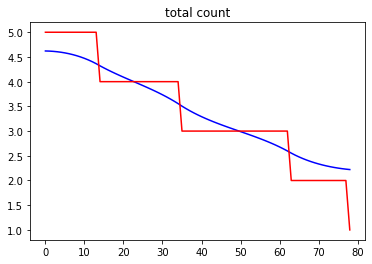

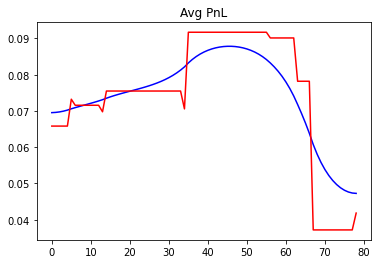

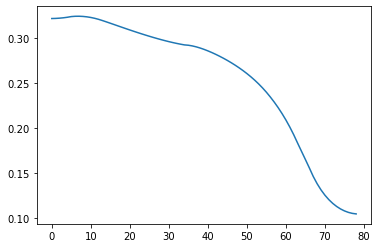

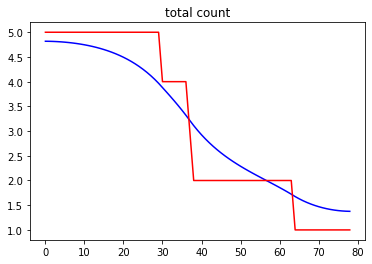

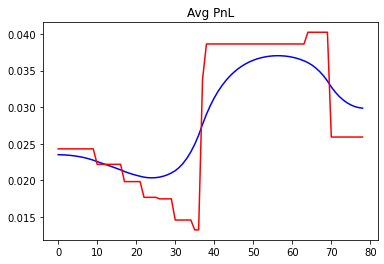

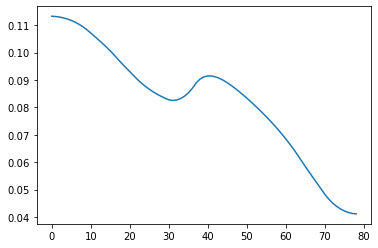

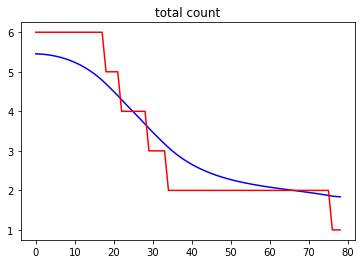

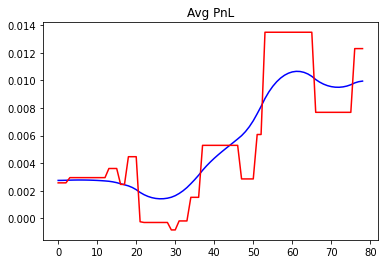

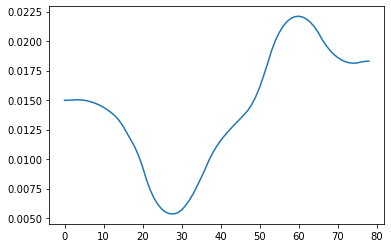

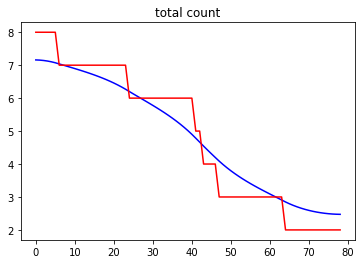

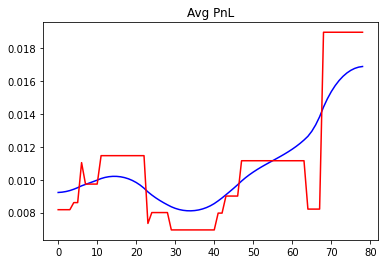

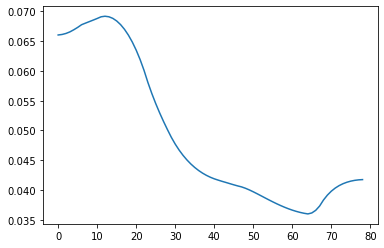

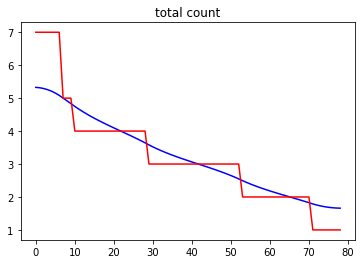

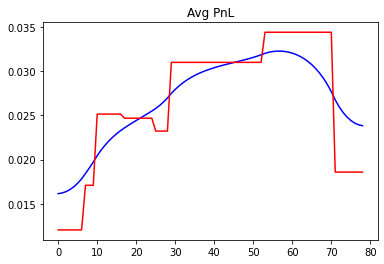

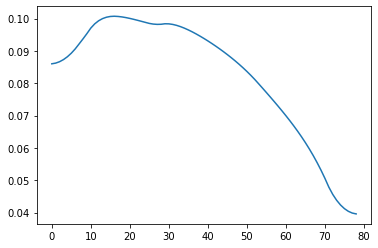

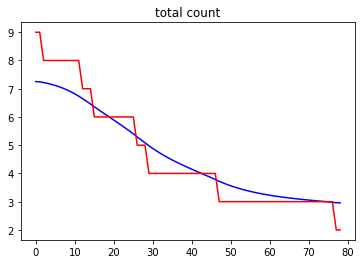

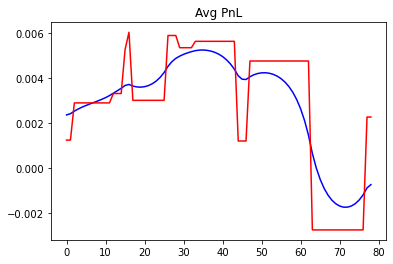

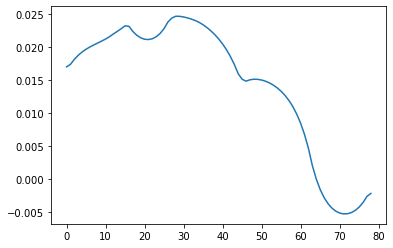

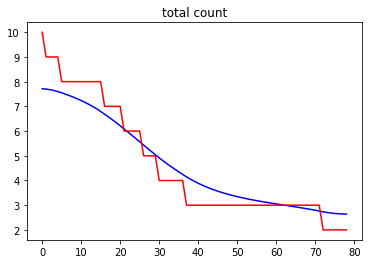

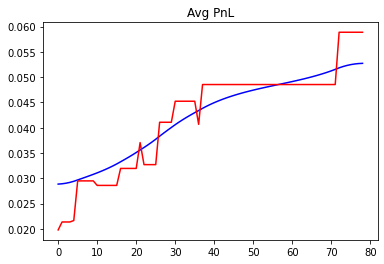

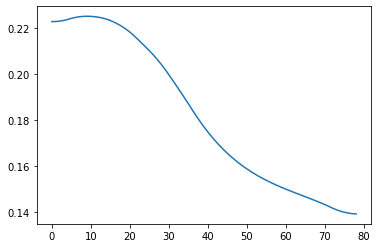

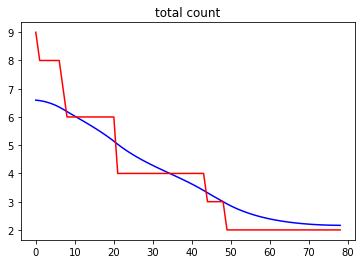

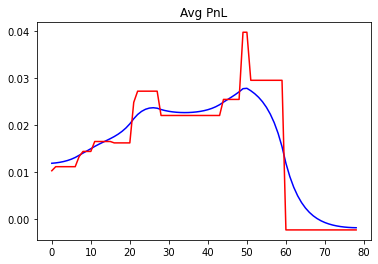

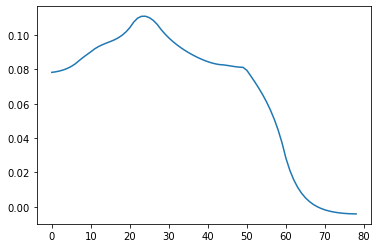

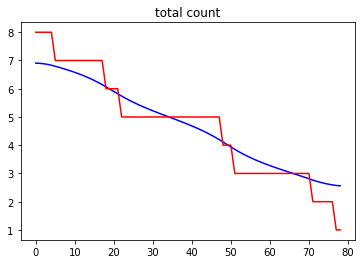

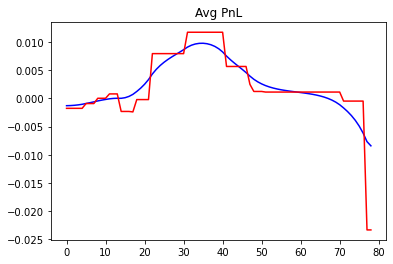

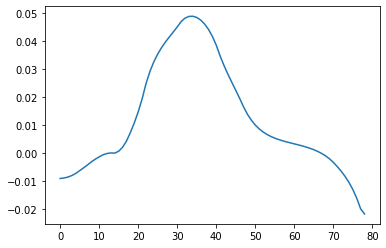

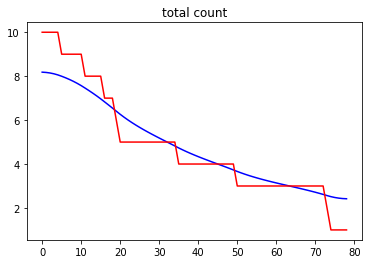

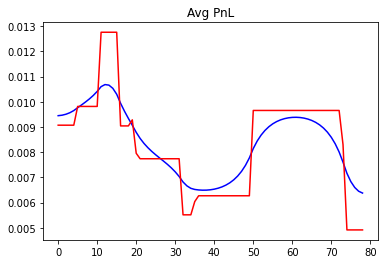

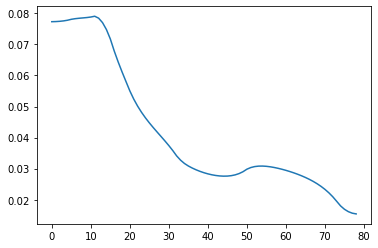

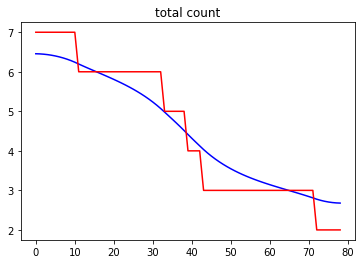

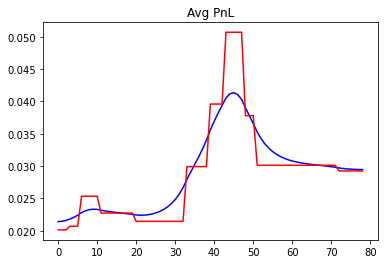

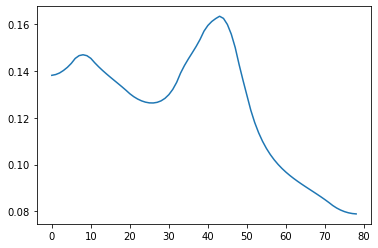

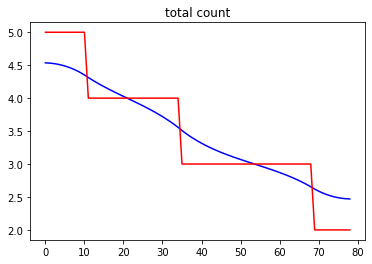

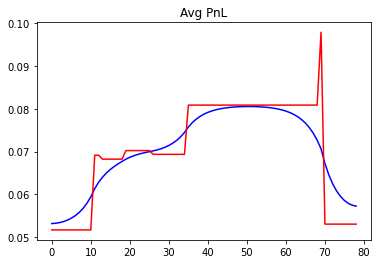

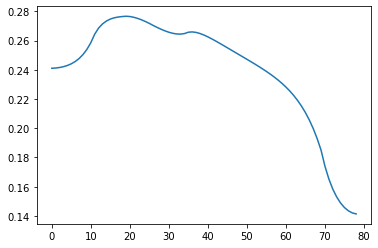

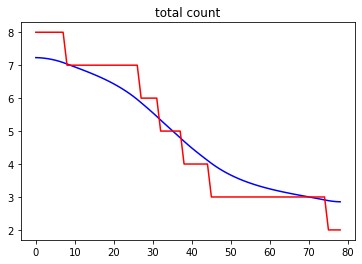

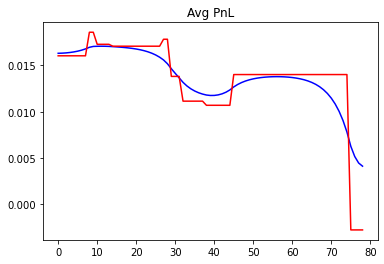

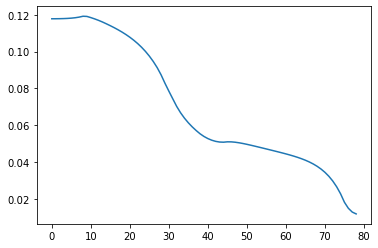

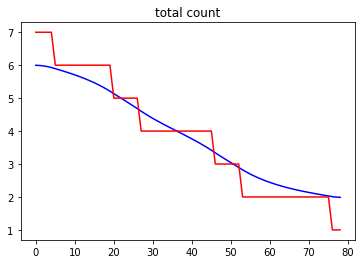

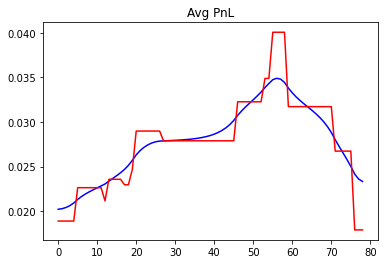

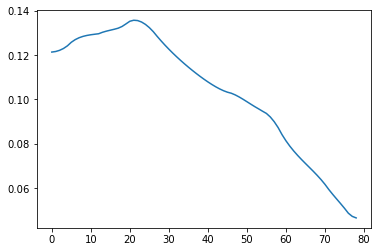

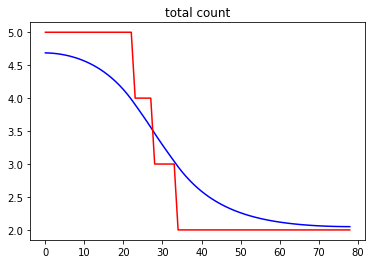

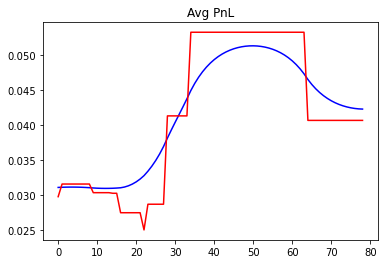

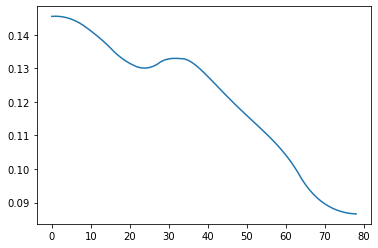

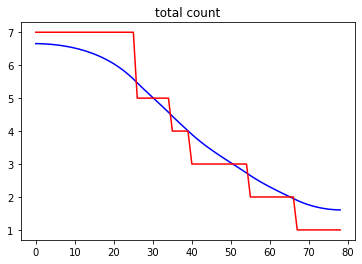

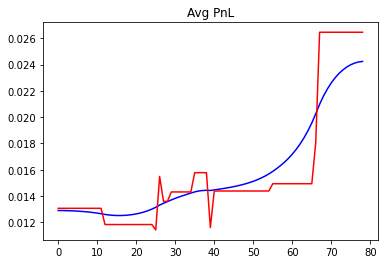

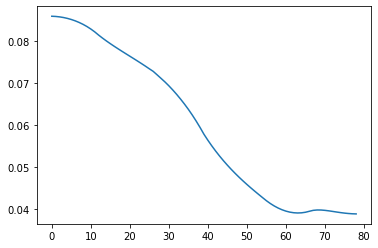

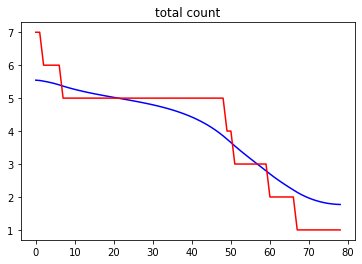

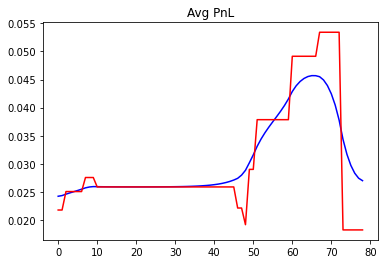

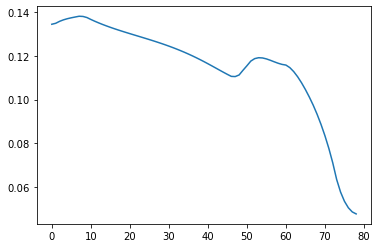

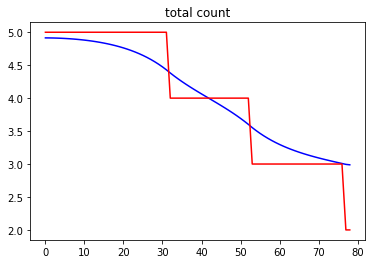

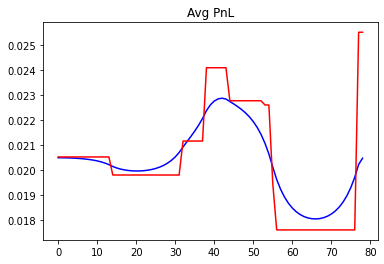

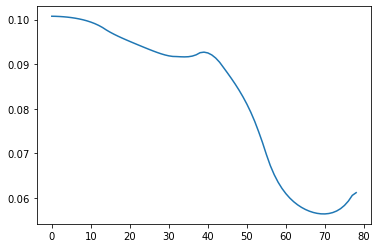

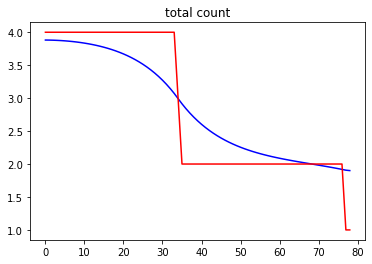

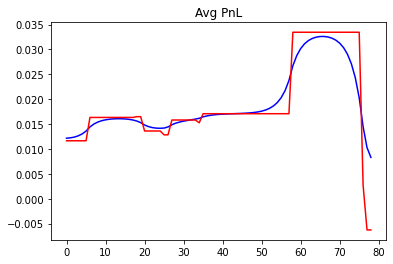

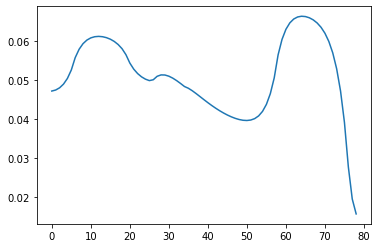

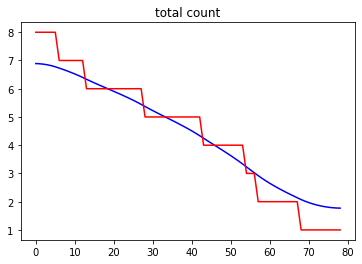

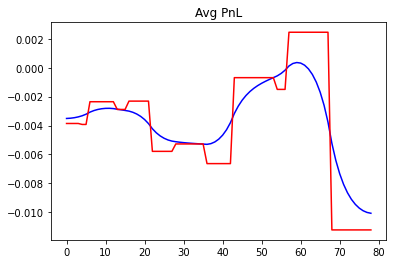

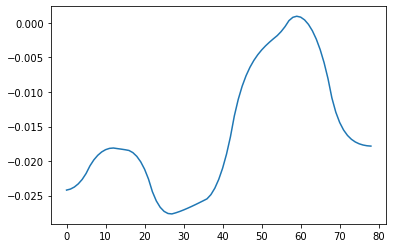

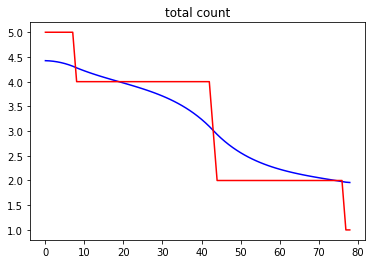

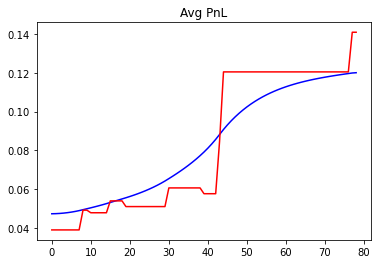

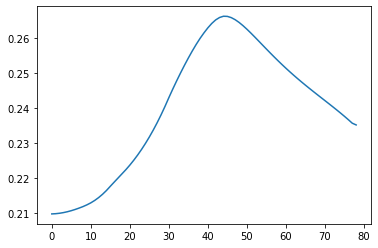

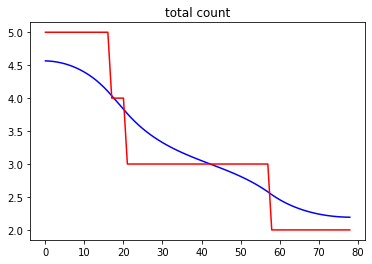

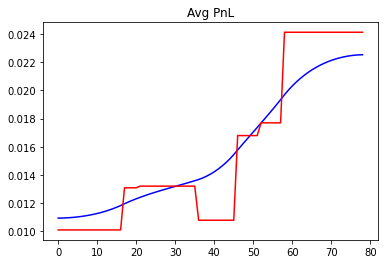

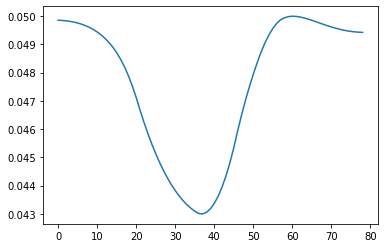

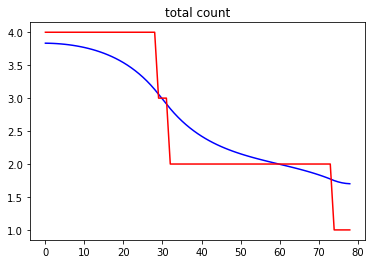

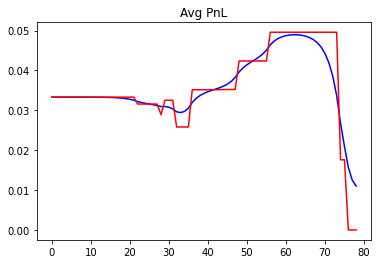

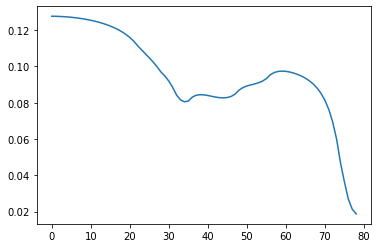

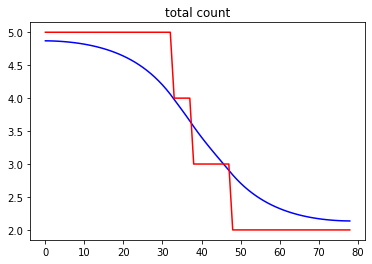

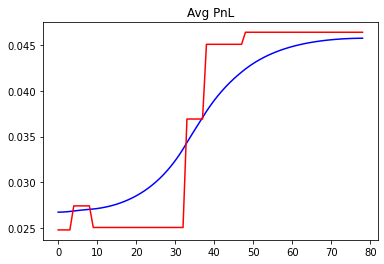

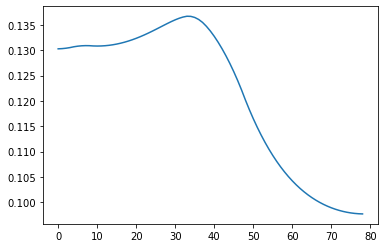

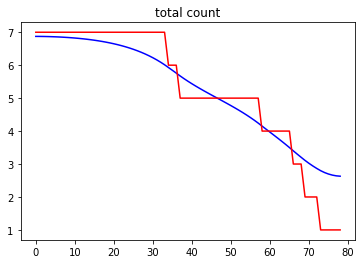

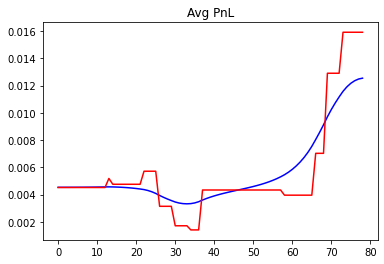

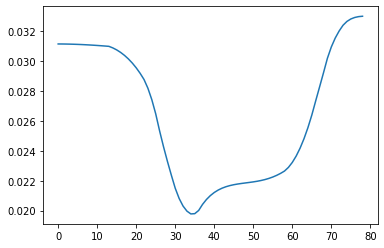

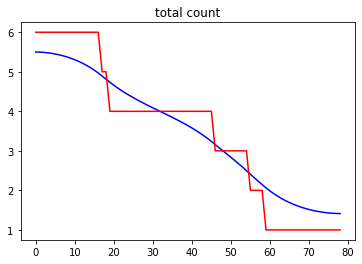

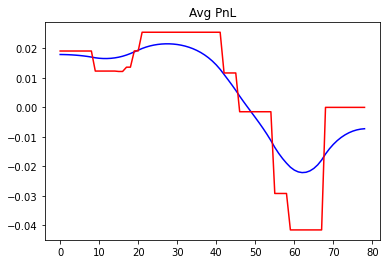

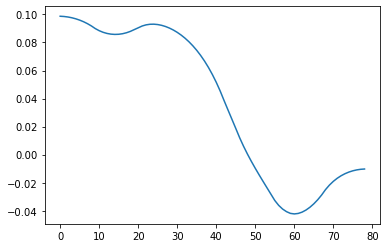

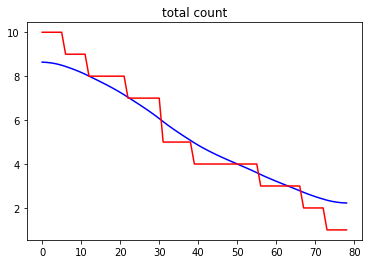

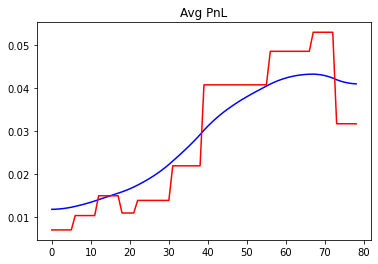

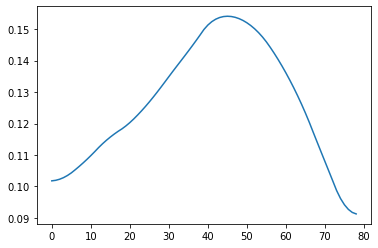

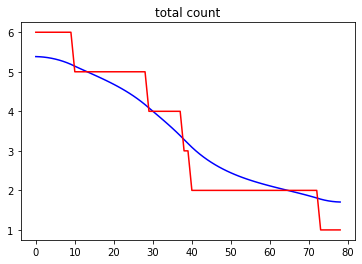

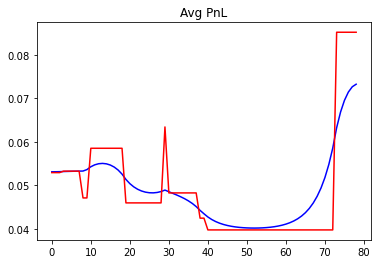

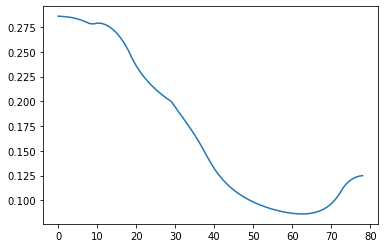

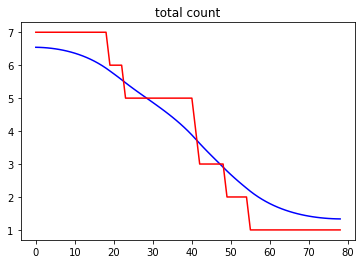

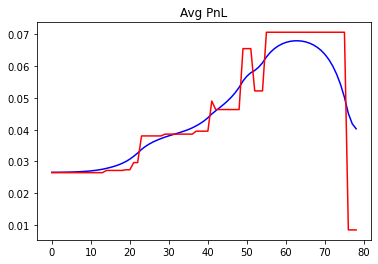

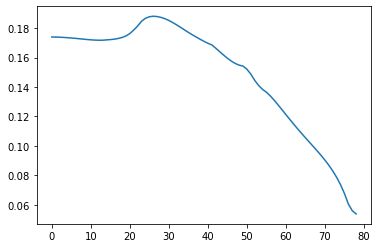

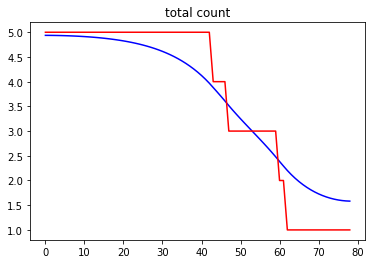

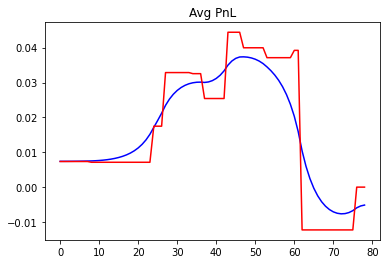

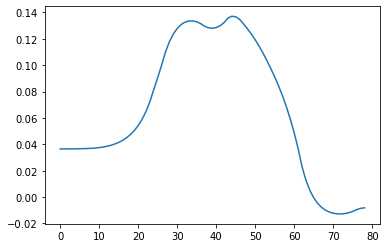

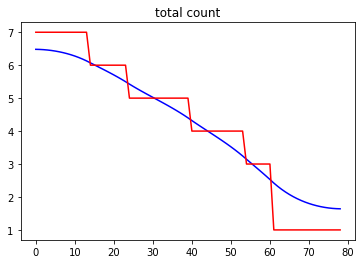

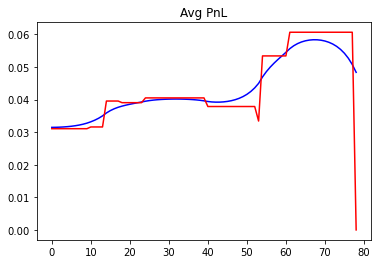

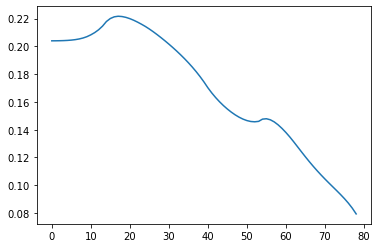

In [285]:
sample_data_index = []
sample_month = -1
monthly_trade_info = []
monthly_pair_characteristic = []
Total_count_list = []
Avg_PnL_list = []

threshold_set = np.array(range(1 , 80)) * 0.025
SL_rate = -0.05

# Scaling the data

scaled_aggregated_df = np.log(aggregated_df) - np.log(aggregated_df.iloc[0])

for i in range (1 , len(scaled_aggregated_df)-1) : 
    
    if len(sample_data_index) == 0:
        
        sample_month = datetime.datetime.strptime(aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data_index.append(i)
    
    next_data_month = datetime.datetime.strptime(aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month or i == len(scaled_aggregated_df)-2:
        
        starting_index = sample_data_index[0]
        ending_index = sample_data_index[-1]
        
        sample_data_index = []
        
        sample_data_open_df = aggregated_open_df.iloc[starting_index+1 : (ending_index+1)]
        sample_data_close_df = aggregated_df.iloc[starting_index+1 : (ending_index+1)]
        scaled_sample_data_df = np.log(sample_data_close_df) - np.log(aggregated_df.iloc[starting_index])
        
        beta_0 , beta_1 , first_asset , second_asset , test_value = ADF_Measure(scaled_sample_data_df)
        
        selected_asset = [first_asset , second_asset]
        coefficient = [beta_0 , beta_1]
        
        pair_characteristic = pd.DataFrame(np.array([first_asset , second_asset , test_value]) ,index = ['first_asset' , 'second_asset' , 'ADF test value'] )
        pair_characteristic = pair_characteristic.T
        
        spread_noise = (scaled_sample_data_df[first_asset] - beta_0 - beta_1*scaled_sample_data_df[second_asset])/np.sqrt(1+beta_1**2)
        
        spread_volatility = np.std(spread_noise)
        
        Total_count = []
        Avg_PnL = []
        
        for threshold in threshold_set : 
            
            trade_info = signal_performance_analysis(scaled_sample_data_df, sample_data_open_df, sample_data_close_df , selected_asset , coefficient , spread_volatility , threshold , SL_rate)
            
            Total_count.append(len(trade_info))
            Avg_PnL.append(np.mean([float(i) for i in trade_info['PnL']]))
            
        Total_count_list.append(Total_count)
        Avg_PnL_list.append(Avg_PnL)
            
        best_threshold = threshold_optimization(threshold_set , Total_count , Avg_PnL)
            
        trade_info = signal_performance_analysis(scaled_sample_data_df, sample_data_open_df, sample_data_close_df , selected_asset , coefficient , spread_volatility , best_threshold , SL_rate)
        
        monthly_trade_info.append(trade_info)
        monthly_pair_characteristic.append(pair_characteristic)

In [286]:
trade_off_rate_set = np.array(range(-12,13))

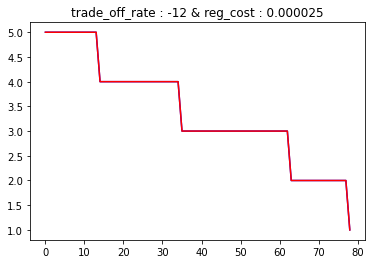

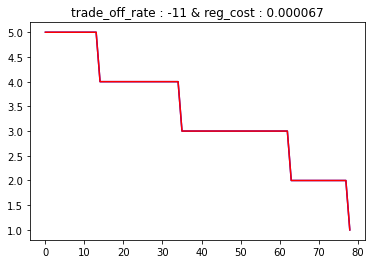

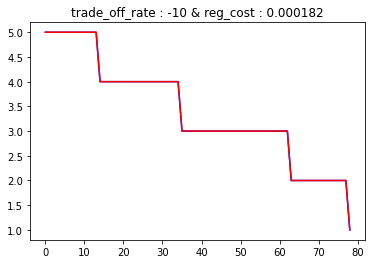

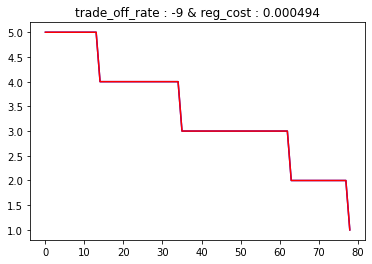

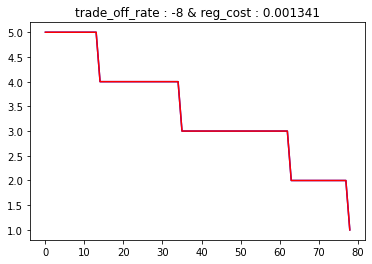

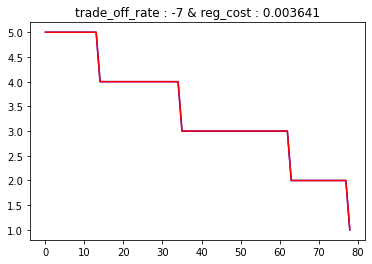

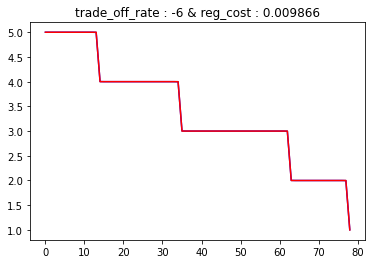

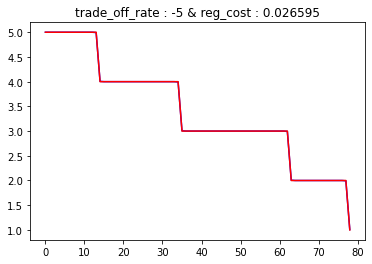

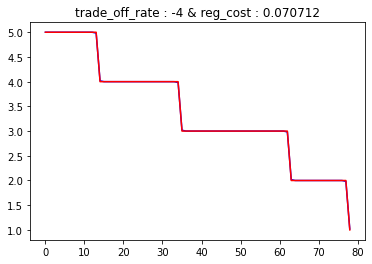

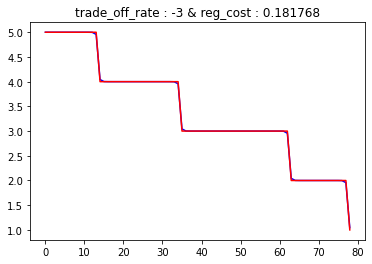

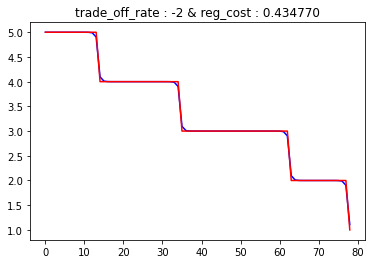

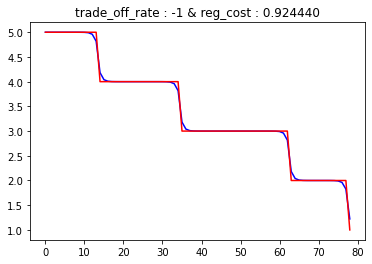

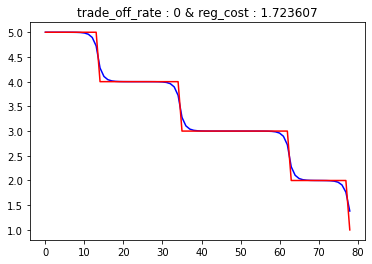

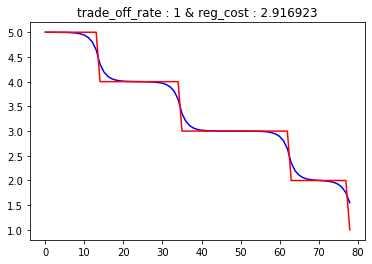

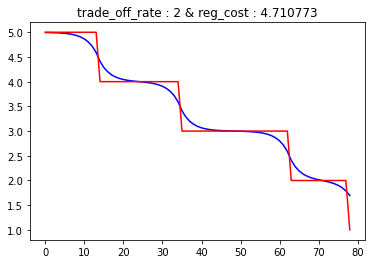

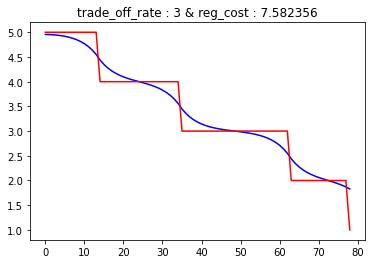

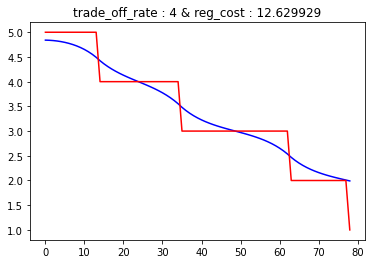

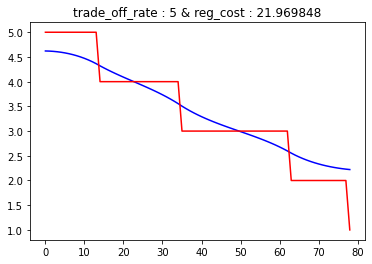

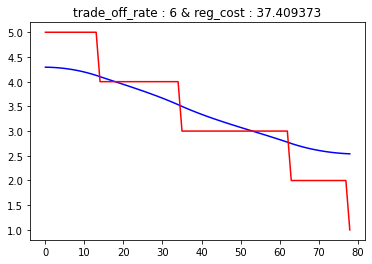

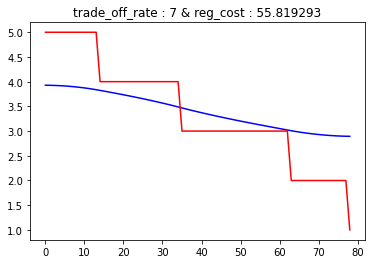

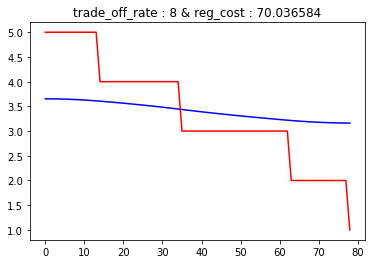

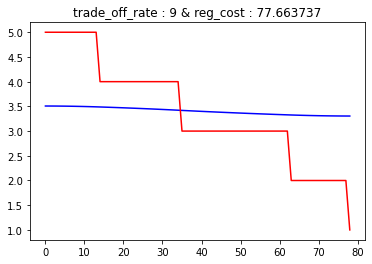

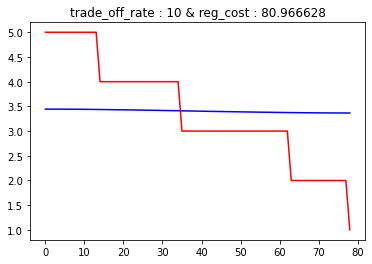

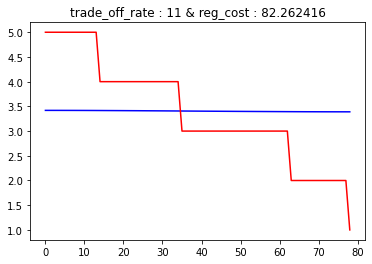

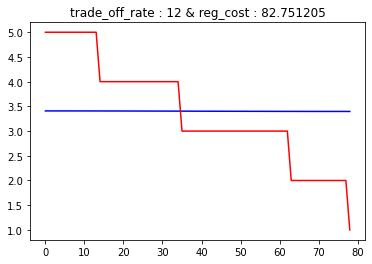

In [287]:
Total_count_reg_cost = []
Total_count = Total_count_list[0]

for trade_off_rate in trade_off_rate_set:
    
    Total_count_res = scipy.optimize.minimize(regularization_cost , np.zeros(len(Total_count)) , args = (np.exp(trade_off_rate) ,Total_count))
    Total_count_cost = regularization_cost(Total_count_res.x, np.exp(trade_off_rate), Total_count)
    Total_count_reg_cost.append(Total_count_cost)
    
    plt.plot(Total_count_res.x , color = 'b')
    plt.plot(Total_count ,  color = 'r')
    plt.title('trade_off_rate : %i & reg_cost : %f' %(trade_off_rate , Total_count_cost))
    plt.show()
    

In [288]:
print(np.mean(Total_count_reg_cost))

21.603862868173984


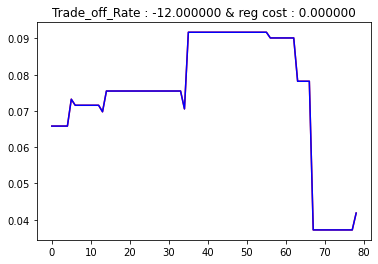

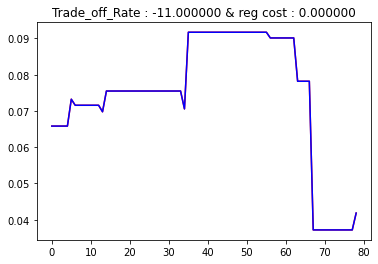

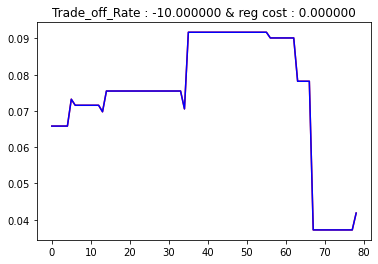

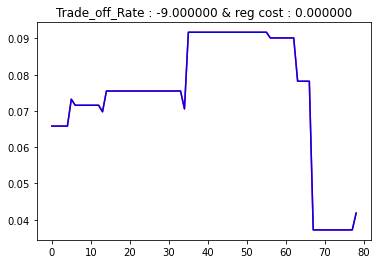

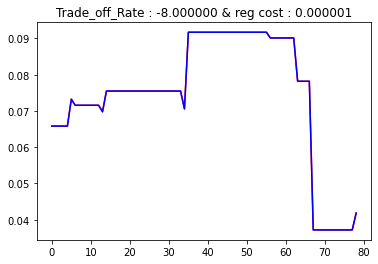

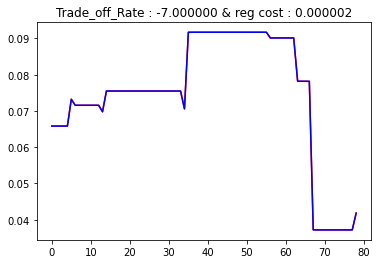

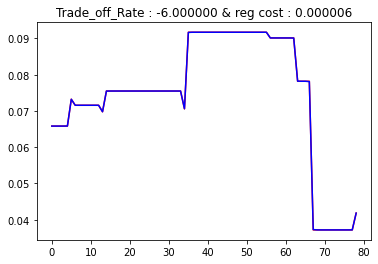

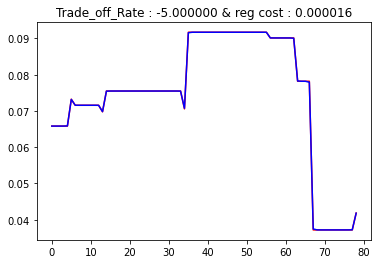

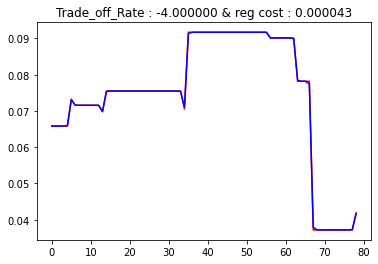

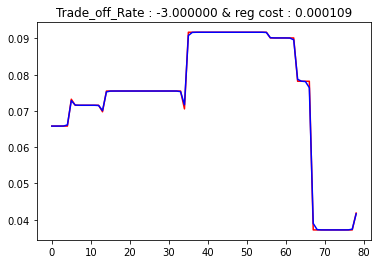

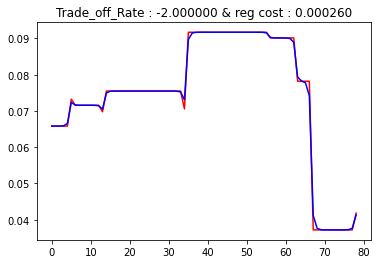

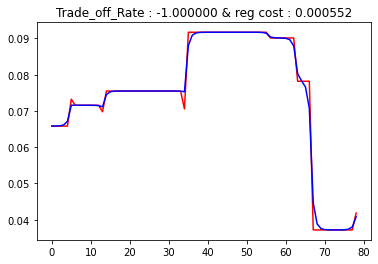

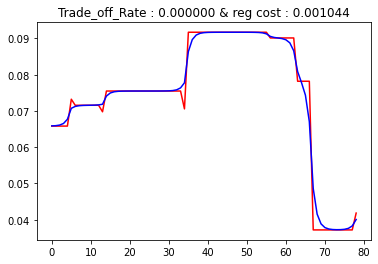

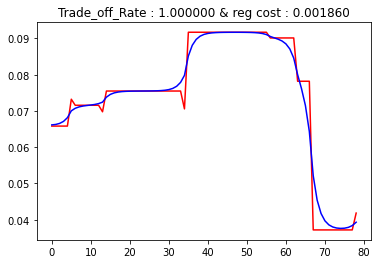

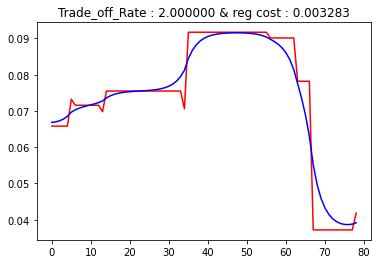

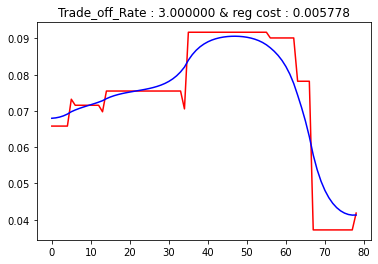

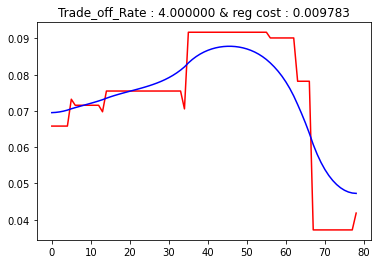

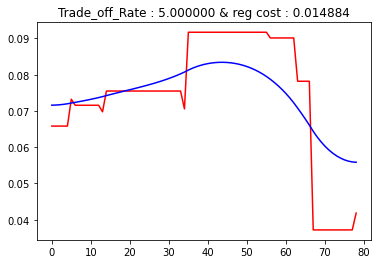

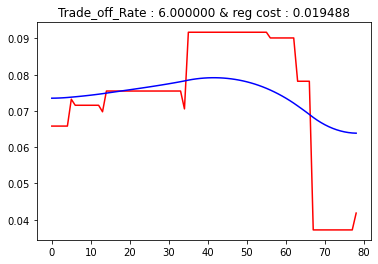

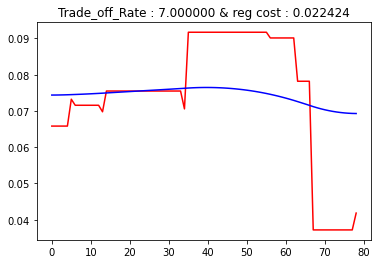

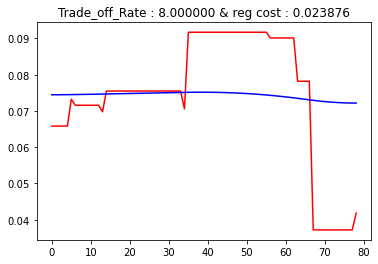

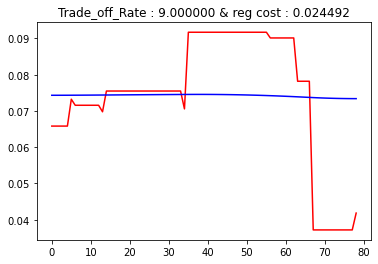

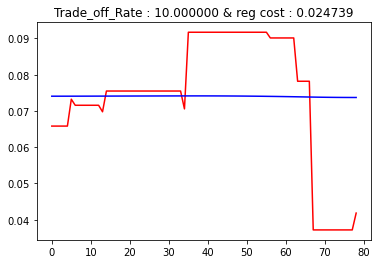

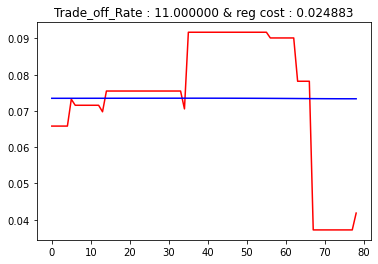

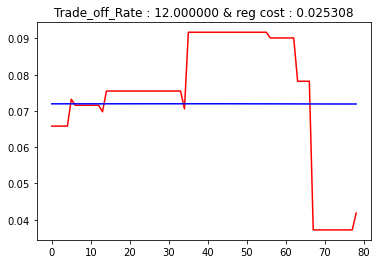

In [289]:
Avg_PnL_reg_cost = []
Avg_PnL = Avg_PnL_list[0]

for trade_off_rate in trade_off_rate_set:
    
    Avg_PnL_res = scipy.optimize.minimize(regularization_cost , np.zeros(len(Avg_PnL)) , args = (np.exp(trade_off_rate) ,Avg_PnL))
    Avg_PnL_cost = regularization_cost(Avg_PnL_res.x, np.exp(trade_off_rate), Avg_PnL)
    Avg_PnL_reg_cost.append(Avg_PnL_cost)
    
    plt.plot(Avg_PnL, color = 'r')
    plt.plot(Avg_PnL_res.x , color = 'b')
    plt.title('Trade_off_Rate : %f & reg cost : %f' % (trade_off_rate , Avg_PnL_cost ))
    plt.show()

In [290]:
print(np.mean(Avg_PnL_reg_cost))

0.008113287676296384


## Part (3) Trading Signal Performance Analysis

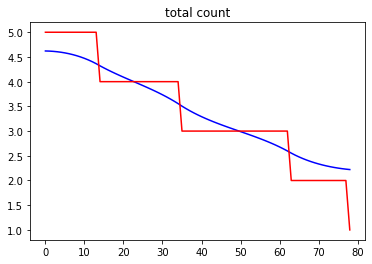

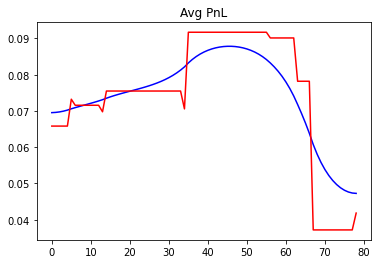

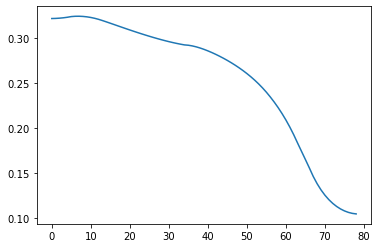

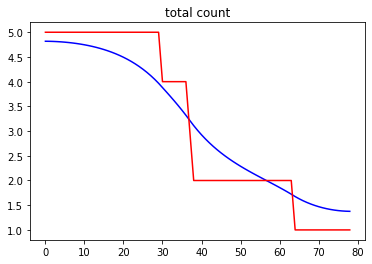

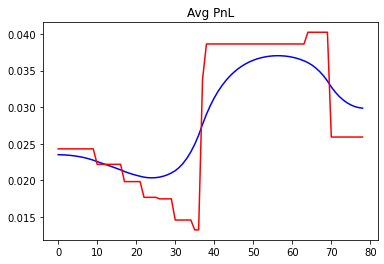

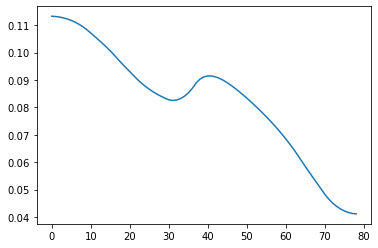

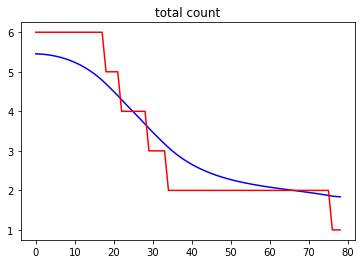

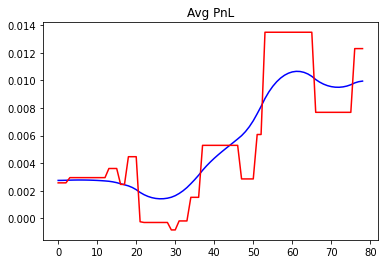

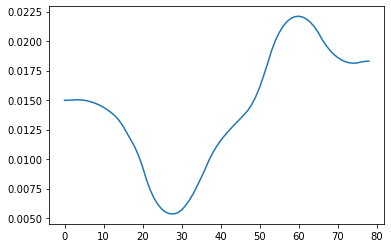

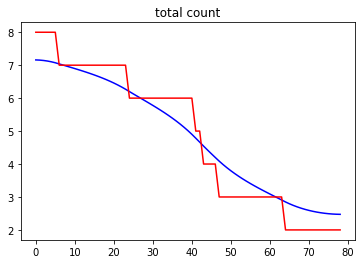

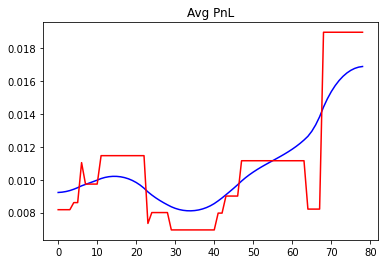

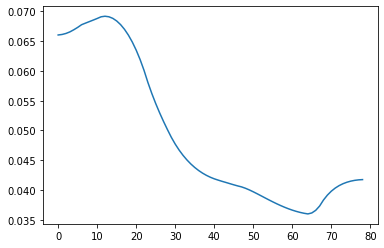

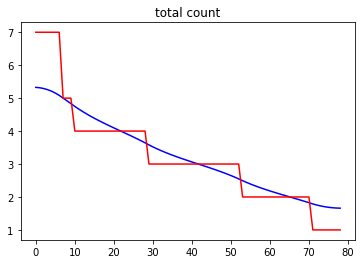

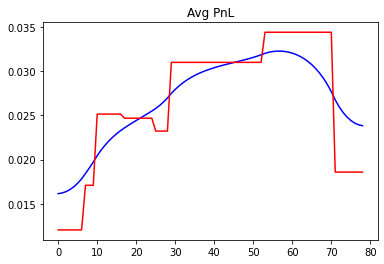

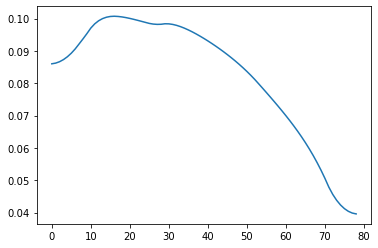

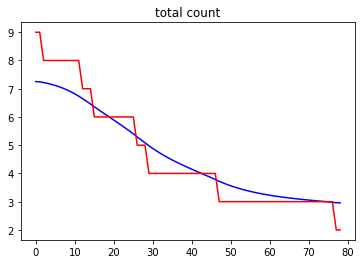

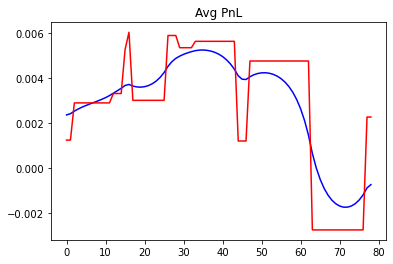

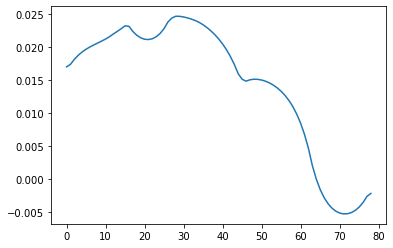

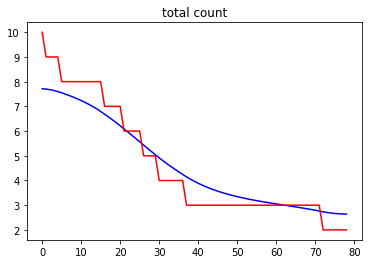

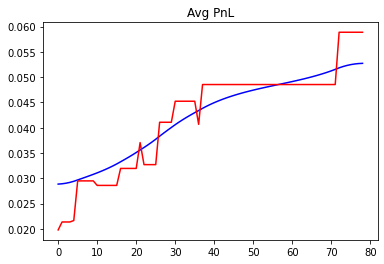

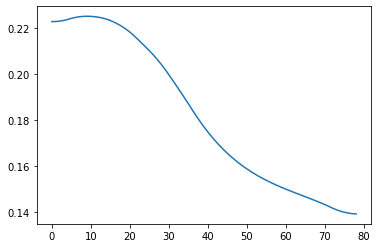

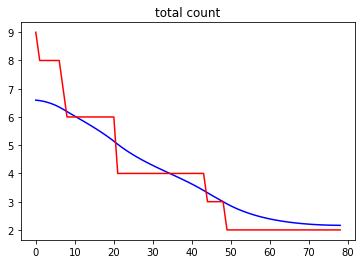

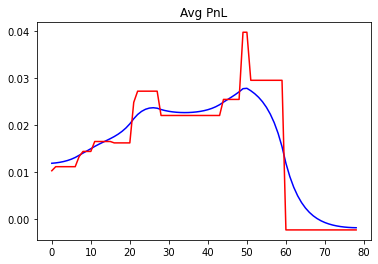

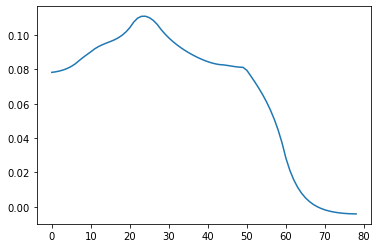

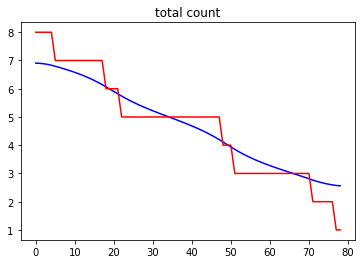

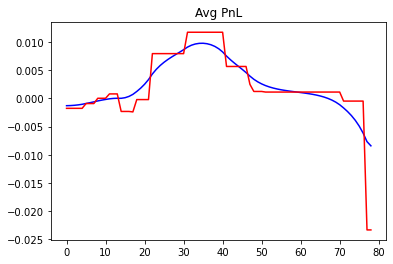

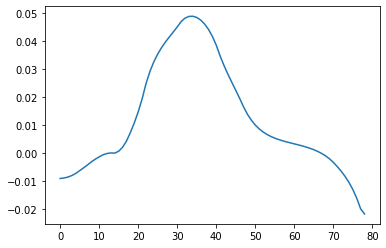

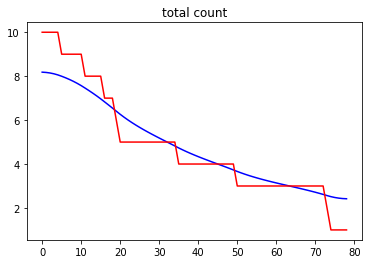

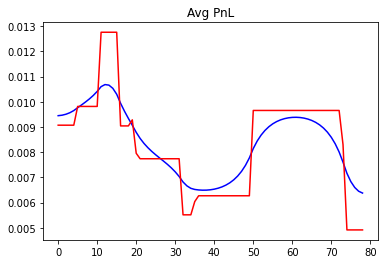

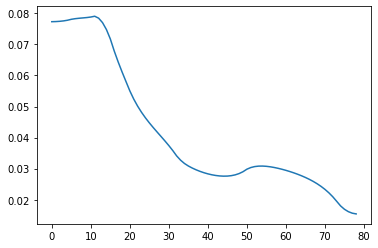

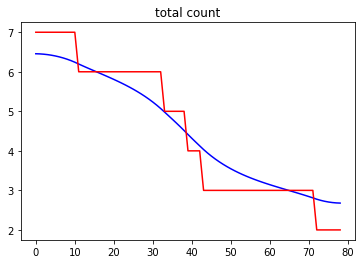

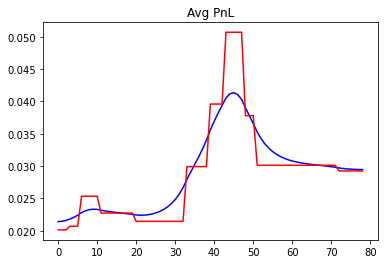

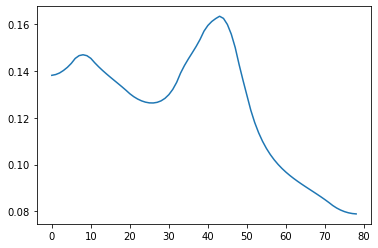

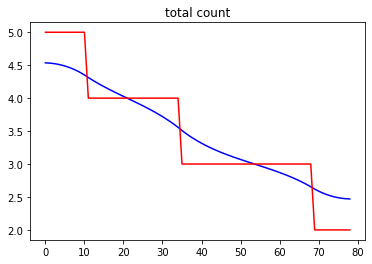

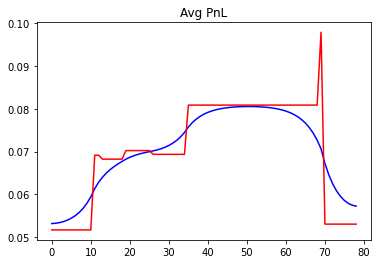

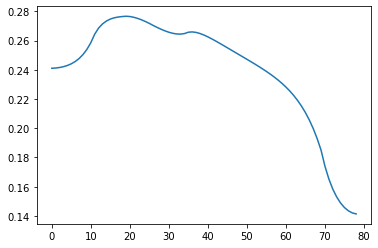

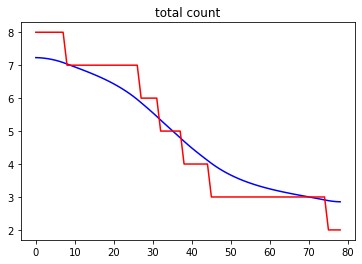

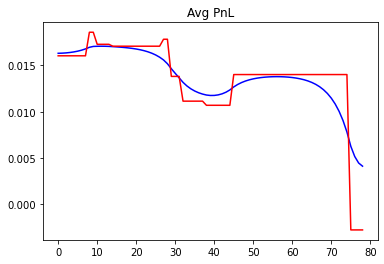

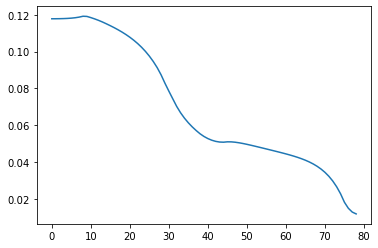

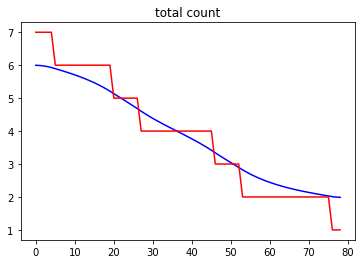

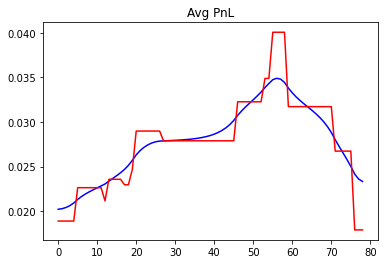

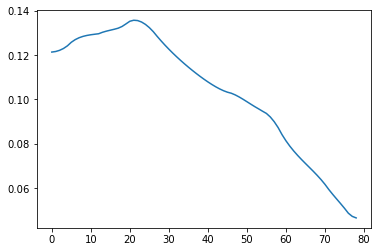

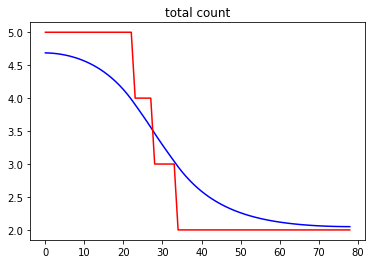

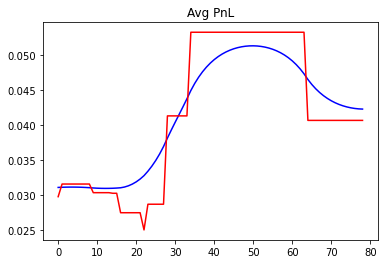

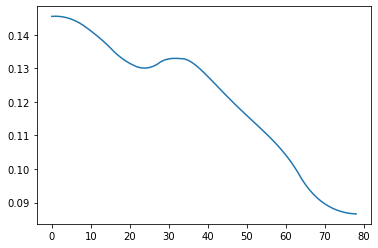

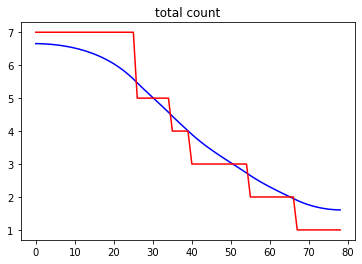

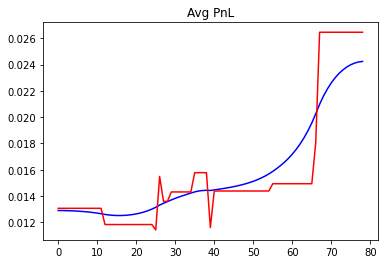

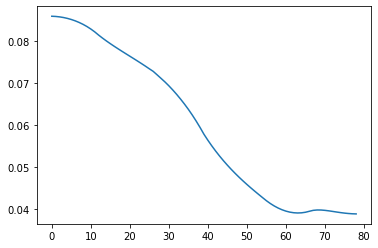

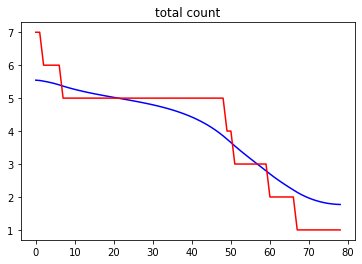

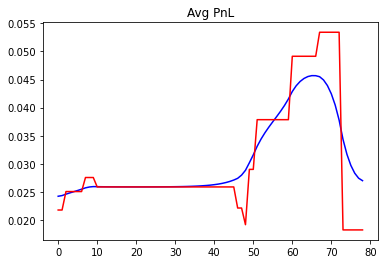

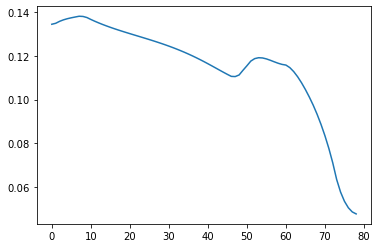

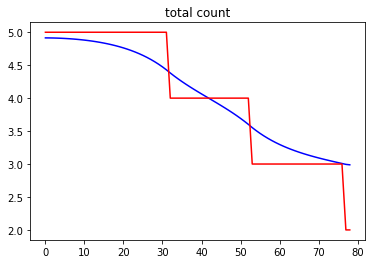

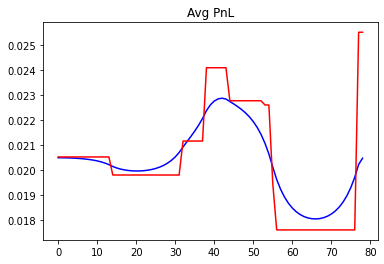

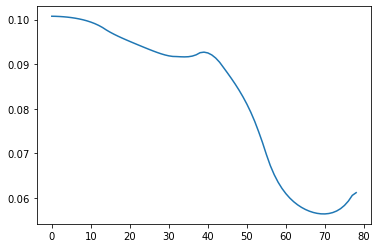

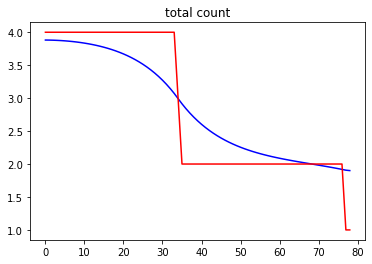

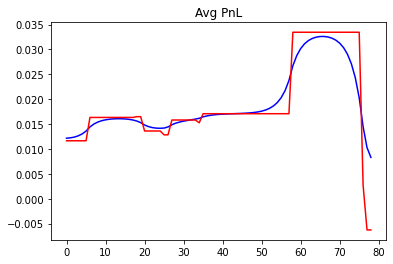

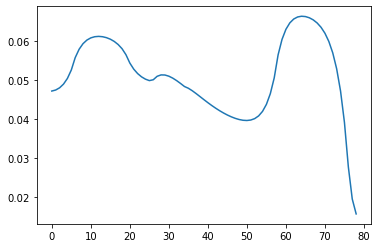

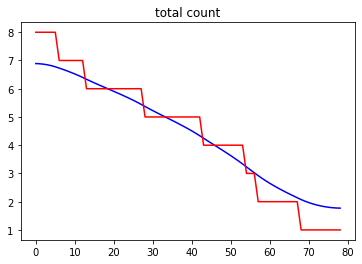

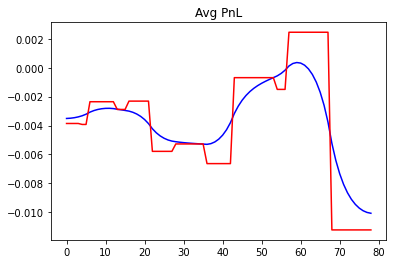

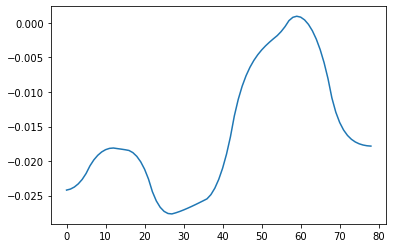

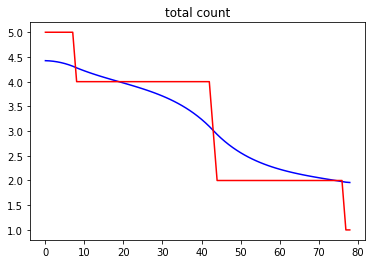

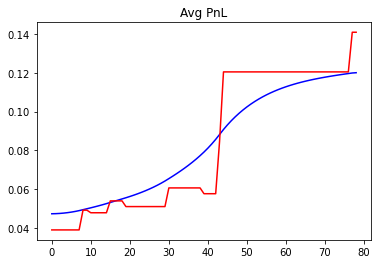

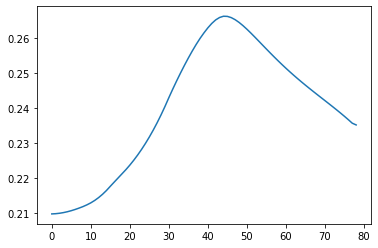

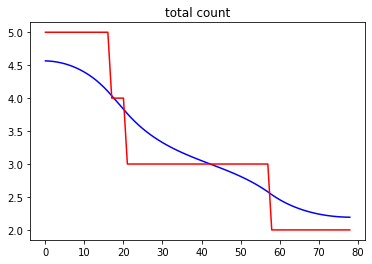

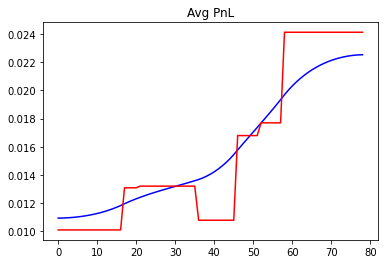

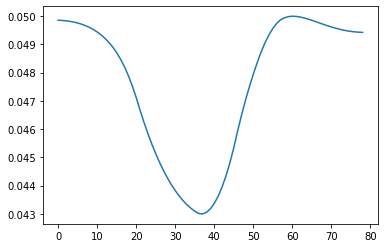

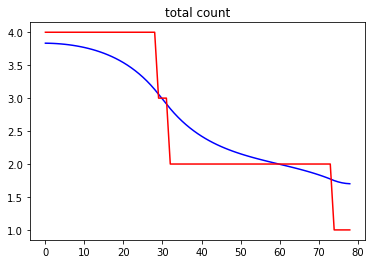

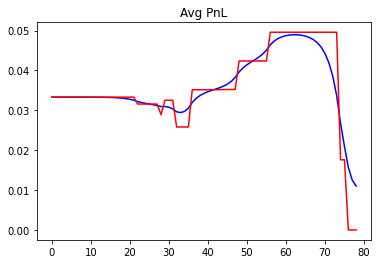

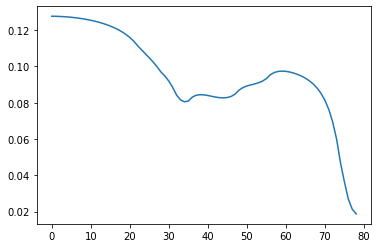

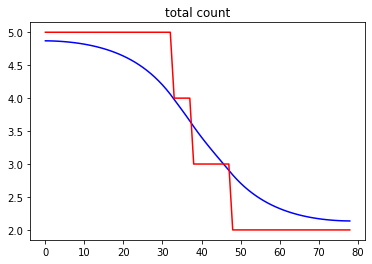

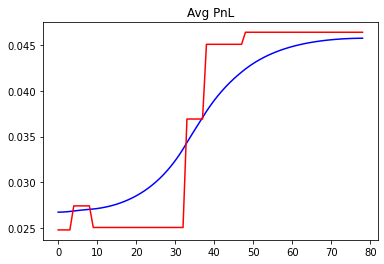

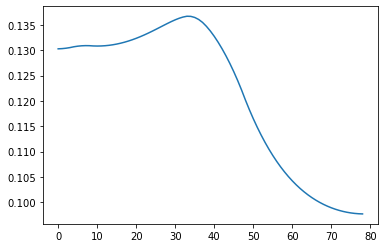

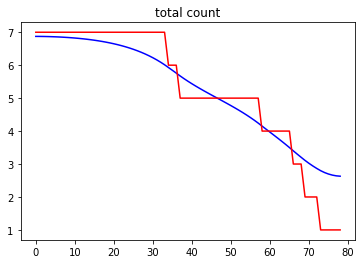

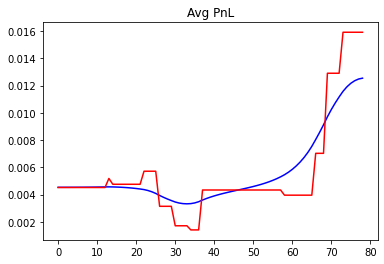

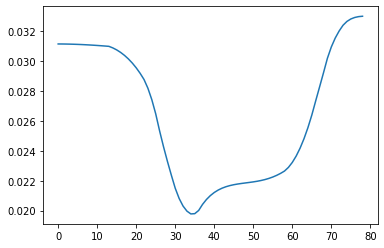

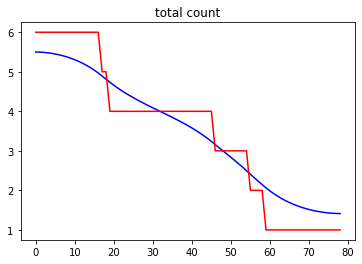

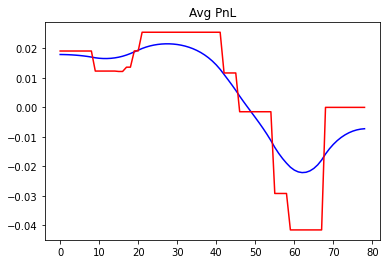

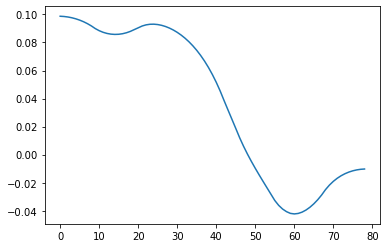

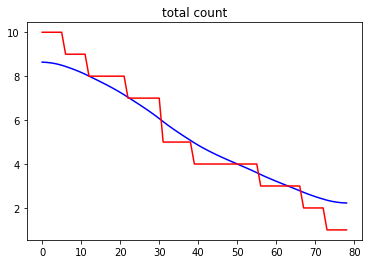

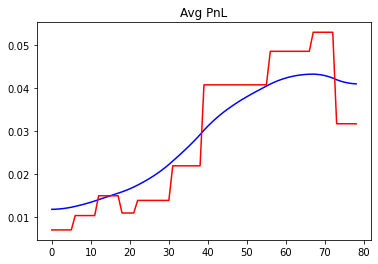

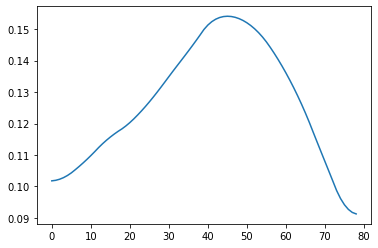

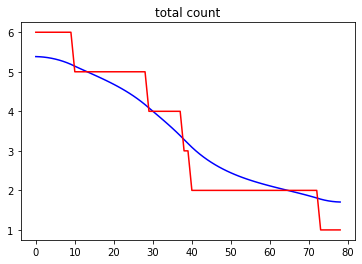

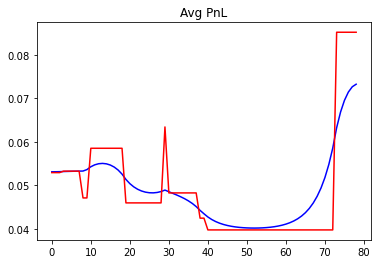

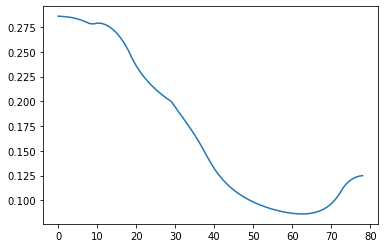

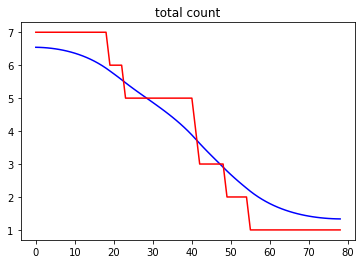

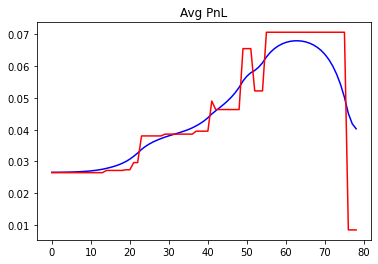

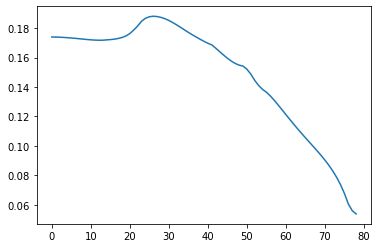

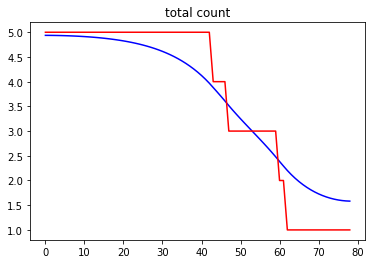

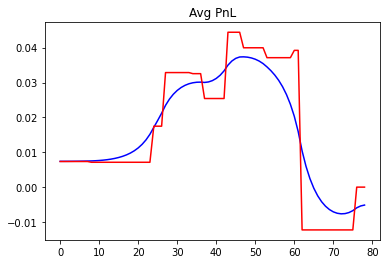

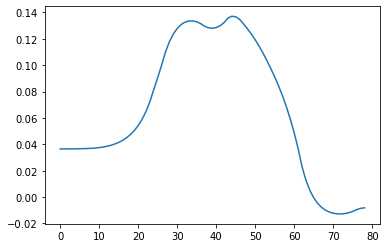

In [329]:
sample_data_index = []
sample_month = -1
monthly_trade_info = []
monthly_prev_trade_info = []
monthly_pair_characteristic = []
monthly_spread = []
monthly_prev_spread = []
monthly_threshold = []

past_reference_point = None
current_reference_point = None

past_sample_data_open_df = []
past_sample_data_close_df = []
past_scaled_sample_data_df = []

current_sample_data_open_df = []
current_sample_data_close_df = []
current_scaled_sample_data_df = []

threshold_set = np.array(range(1 , 80)) * 0.025
SL_rate = -0.05

for i in range (1 , len(scaled_aggregated_df)-1) : 
    
    if len(sample_data_index) == 0:
        
        sample_month = datetime.datetime.strptime(aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data_index.append(i)
    
    next_data_month = datetime.datetime.strptime(aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month or i == len(scaled_aggregated_df)-2:
        
        starting_index = sample_data_index[0]
        ending_index = sample_data_index[-1]
        
        sample_data_index = []
            
        past_sample_data_open_df = current_sample_data_open_df
        past_sample_data_close_df = current_sample_data_close_df
        past_reference_point = current_reference_point
        
        current_sample_data_open_df = aggregated_open_df.iloc[starting_index+1 : (ending_index+1)]
        current_sample_data_close_df = aggregated_df.iloc[starting_index+1 : (ending_index+1)]
        current_reference_point = np.log(aggregated_df.iloc[starting_index])
        
        if (len(past_sample_data_open_df) == 0):
            continue
            
        past_scaled_sample_data_df = np.log(past_sample_data_close_df) - past_reference_point
        current_scaled_sample_data_df = np.log(current_sample_data_close_df) - past_reference_point
        
        beta_0 , beta_1 , first_asset , second_asset , test_value = ADF_Measure(past_scaled_sample_data_df)
        
        selected_asset = [first_asset , second_asset]
        coefficient = [beta_0 , beta_1]
        
        pair_characteristic = pd.DataFrame(np.array([first_asset , second_asset , test_value]) ,index = ['first_asset' , 'second_asset' , 'ADF test value'] )
        pair_characteristic = pair_characteristic.T
        
        spread_noise = (past_scaled_sample_data_df[first_asset] - beta_0 - beta_1*past_scaled_sample_data_df[second_asset])/np.sqrt(1+beta_1**2)
        
        spread_volatility = np.std(spread_noise)
        
        past_spread_std_noise = spread_noise/spread_volatility
        
        current_spread_noise = (current_scaled_sample_data_df[first_asset] - beta_0 - beta_1*current_scaled_sample_data_df[second_asset])/np.sqrt(1+beta_1**2)
        
        current_spread_volatility = np.std(current_spread_noise)
        
        current_spread_std_noise = current_spread_noise/current_spread_volatility
        
        Total_count = []
        Avg_PnL = []
        
        for threshold in threshold_set : 
            
            trade_info = signal_performance_analysis(past_scaled_sample_data_df, past_sample_data_open_df, past_sample_data_close_df , selected_asset , coefficient , spread_volatility , threshold , SL_rate)
            
            Total_count.append(len(trade_info))
            Avg_PnL.append(np.mean([float(i) for i in trade_info['PnL']]))
            
        best_threshold = threshold_optimization(threshold_set , Total_count , Avg_PnL)
            
        trade_info = signal_performance_analysis(current_scaled_sample_data_df, current_sample_data_open_df, current_sample_data_close_df , selected_asset , coefficient , spread_volatility , best_threshold , SL_rate)
        prev_trade_info = signal_performance_analysis(past_scaled_sample_data_df, past_sample_data_open_df, past_sample_data_close_df , selected_asset , coefficient , spread_volatility , best_threshold , SL_rate)
        
        monthly_spread.append(current_spread_std_noise)
        monthly_threshold.append(best_threshold)
        monthly_trade_info.append(trade_info)
        monthly_prev_trade_info.append(prev_trade_info)
        monthly_prev_spread.append(past_spread_std_noise)
        monthly_pair_characteristic.append(pair_characteristic)

In [346]:
trade_info =  monthly_trade_info[9]

In [352]:
trade_info

trade date trading_signal long asset short asset long cost short cost  \
0  2019-04-03              1   ADA/USDT    XRP/USDT   0.09062    0.34022   
1  2019-04-25             -1   XRP/USDT    ADA/USDT   0.29161    0.06956   

   close date long close short close trading period                   PnL  \
0  2019-04-05    0.08988     0.35264              3  -0.03718448986584379   
1  2019-04-29     0.3087      0.0701              5   0.06019511168825807   

  coverage  
0       SL  
1        N

In [354]:
sum(trade_info['coverage']=='SL')

1

In [348]:
trade_info['trade date'][0][:-3]

'2019-04'

In [335]:
pair_info = monthly_pair_characteristic[0]

In [339]:
pair_info

first_asset second_asset      ADF test value
0    ADA/USDT     BNB/USDT  -2.845172890014475

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & BNB/USDT
ADF Test Value : -2.845172890014475
Threshold : 0.2
                    0         1
Total Trade  5.000000  1.000000
Avg PnL      0.071577 -0.073511
SL Rate      0.000000  1.000000


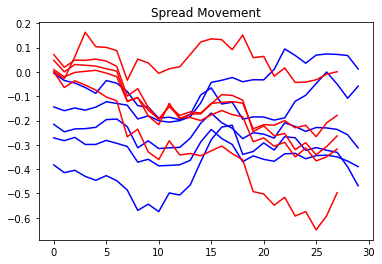

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ETH/USDT
ADF Test Value : -2.41303481125463
Threshold : 0.025
                    0         1
Total Trade  5.000000  1.000000
Avg PnL      0.024304 -0.061487
SL Rate      0.000000  1.000000


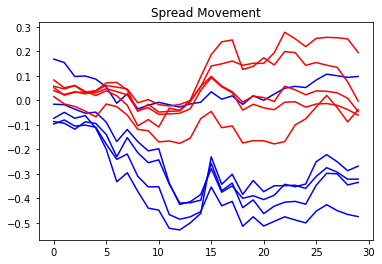

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ADA/USDT
ADF Test Value : -2.4345011810222403
Threshold : 1.5250000000000001
                    0        1
Total Trade  2.000000  1.00000
Avg PnL      0.013501 -0.06476
SL Rate      0.000000  1.00000


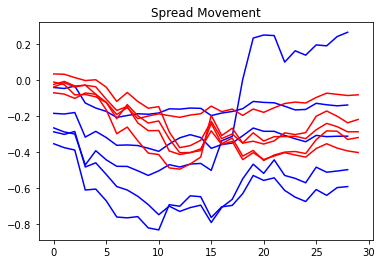

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & BTC/USDT
ADF Test Value : -3.2831738072091956
Threshold : 0.325
                    0         1
Total Trade  7.000000  3.000000
Avg PnL      0.011462  0.008677
SL Rate      0.000000  0.000000


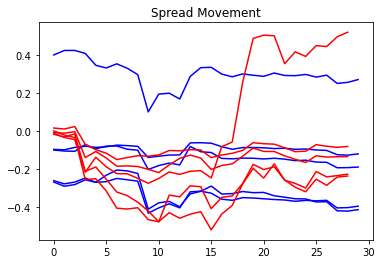

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & BNB/USDT
ADF Test Value : -3.0186446134959706
Threshold : 0.42500000000000004
                    0         1
Total Trade  4.000000  1.000000
Avg PnL      0.025147 -0.096871
SL Rate      0.000000  1.000000


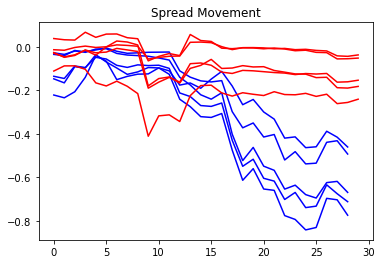

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & BTC/USDT
ADF Test Value : -5.094946220673529
Threshold : 0.7250000000000001
                    0         1
Total Trade  5.000000  4.000000
Avg PnL      0.005878  0.006076
SL Rate      0.000000  0.000000


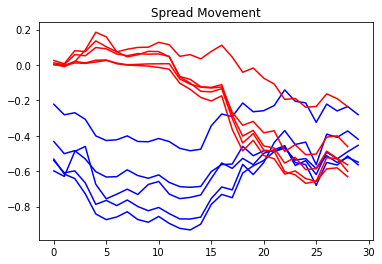

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & XRP/USDT
ADF Test Value : -6.8118937074417145
Threshold : 0.25
                    0         1
Total Trade  8.000000  1.000000
Avg PnL      0.029498 -0.044312
SL Rate      0.000000  1.000000


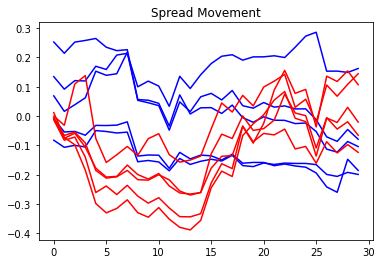

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ETH/USDT & XRP/USDT
ADF Test Value : -4.118140841128464
Threshold : 0.625
                    0         1
Total Trade  4.000000  1.000000
Avg PnL      0.027241 -0.071478
SL Rate      0.000000  1.000000


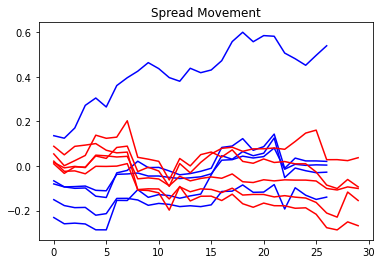

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ETH/USDT & XRP/USDT
ADF Test Value : -4.977822129307087
Threshold : 0.875
                    0        1
Total Trade  5.000000  2.00000
Avg PnL      0.011748  0.00094
SL Rate      0.000000  0.00000


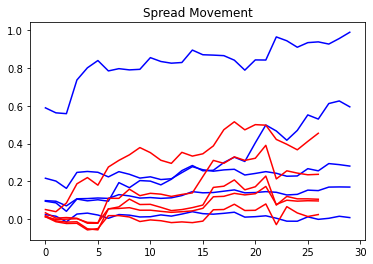

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : XRP/USDT & ADA/USDT
ADF Test Value : -3.866391424213671
Threshold : 0.30000000000000004
                    0         1
Total Trade  8.000000  2.000000
Avg PnL      0.012763  0.011505
SL Rate      0.000000  0.500000


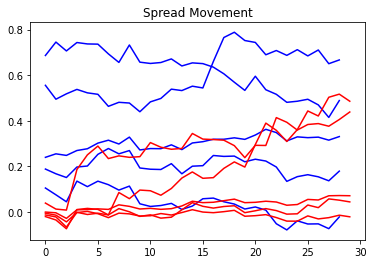

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BTC/USDT & ADA/USDT
ADF Test Value : -4.118274577514701
Threshold : 1.1
                    0        1
Total Trade  3.000000  1.00000
Avg PnL      0.050700 -0.10587
SL Rate      0.333333  1.00000


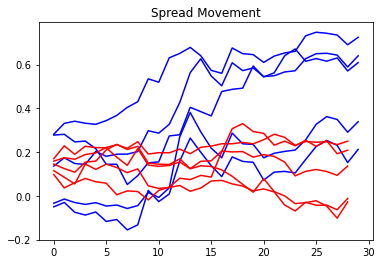

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BTC/USDT & ADA/USDT
ADF Test Value : -2.9742797713292557
Threshold : 0.5
                    0         1
Total Trade  4.000000  3.000000
Avg PnL      0.070234 -0.015708
SL Rate      0.000000  0.333333


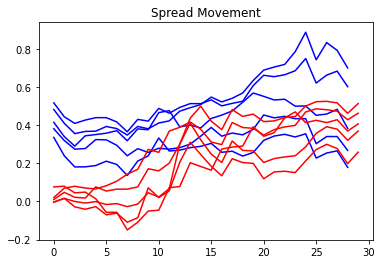

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BTC/USDT & ETH/USDT
ADF Test Value : -3.30859089997833
Threshold : 0.225
                    0         1
Total Trade  7.000000  1.000000
Avg PnL      0.018569 -0.113933
SL Rate      0.000000  1.000000


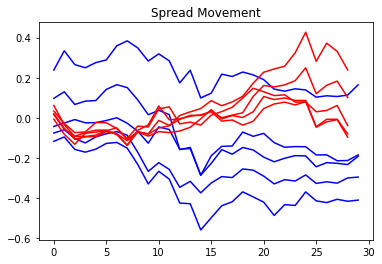

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : XRP/USDT & BNB/USDT
ADF Test Value : -2.6378166874340567
Threshold : 0.55
                    0         1
Total Trade  5.000000  3.000000
Avg PnL      0.028989  0.054304
SL Rate      0.000000  0.000000


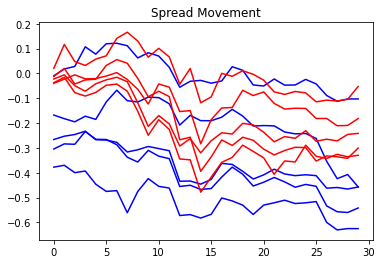

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & BTC/USDT
ADF Test Value : -3.104505959334634
Threshold : 0.05
                    0         1
Total Trade  5.000000  3.000000
Avg PnL      0.031534  0.040662
SL Rate      0.000000  0.000000


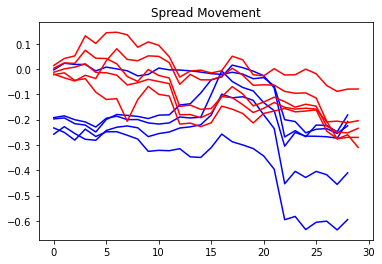

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & BTC/USDT
ADF Test Value : -3.099420825266941
Threshold : 0.025
                    0         1
Total Trade  7.000000  1.000000
Avg PnL      0.013069 -0.058264
SL Rate      0.000000  1.000000


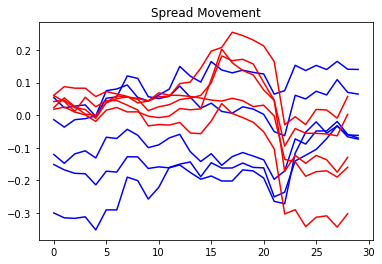

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & XRP/USDT
ADF Test Value : -2.7398700446499156
Threshold : 0.2
                    0         1
Total Trade  5.000000  1.000000
Avg PnL      0.027566 -0.061375
SL Rate      0.000000  1.000000


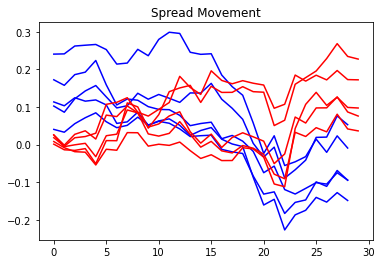

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ETH/USDT
ADF Test Value : -2.2322243317810675
Threshold : 0.025
                    0         1
Total Trade  5.000000  5.000000
Avg PnL      0.020528  0.002244
SL Rate      0.000000  0.000000


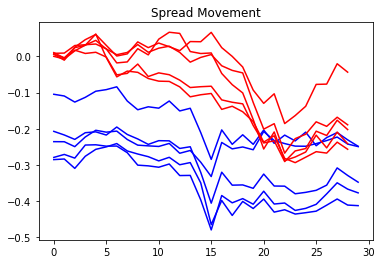

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & BTC/USDT
ADF Test Value : -2.5710603699150285
Threshold : 1.625
                    0         1
Total Trade  2.000000  1.000000
Avg PnL      0.033451 -0.027853
SL Rate      0.000000  0.000000


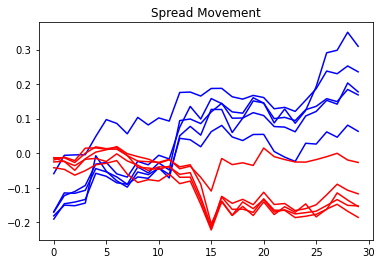

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ETH/USDT
ADF Test Value : -4.419767274878445
Threshold : 1.5
                    0        1
Total Trade  2.000000  3.00000
Avg PnL      0.002452  0.04973
SL Rate      0.000000  0.00000


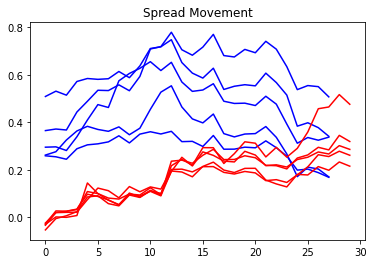

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & XRP/USDT
ADF Test Value : -1.5719804218865392
Threshold : 1.125
                    0         1
Total Trade  2.000000  1.000000
Avg PnL      0.120432  0.009348
SL Rate      0.000000  0.000000


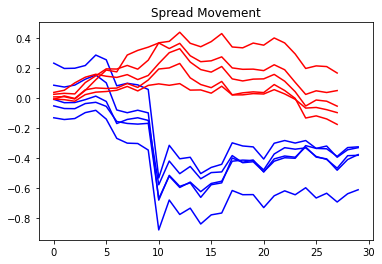

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ADA/USDT
ADF Test Value : -2.27628079438958
Threshold : 1.5250000000000001
                    0         1
Total Trade  2.000000  2.000000
Avg PnL      0.024142 -0.036261
SL Rate      0.000000  1.000000


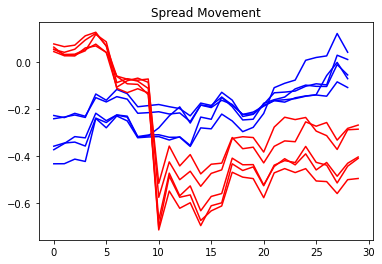

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & XRP/USDT
ADF Test Value : -2.5414790706359303
Threshold : 0.025
                    0         1
Total Trade  4.000000  2.000000
Avg PnL      0.033305  0.006831
SL Rate      0.000000  0.500000


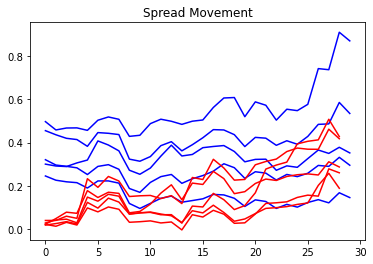

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & BNB/USDT
ADF Test Value : -2.8872955575255137
Threshold : 0.8500000000000001
                    0         1
Total Trade  4.000000  1.000000
Avg PnL      0.036921 -0.060775
SL Rate      0.000000  1.000000


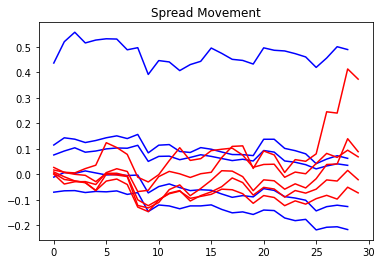

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & BTC/USDT
ADF Test Value : -3.9114509886551114
Threshold : 1.975
                    0         1
Total Trade  1.000000  2.000000
Avg PnL      0.015923  0.022923
SL Rate      0.000000  0.000000


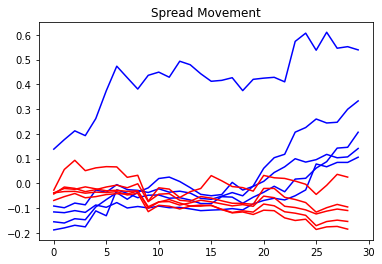

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : ADA/USDT & XRP/USDT
ADF Test Value : -2.4608401320942925
Threshold : 0.025
                    0         1
Total Trade  6.000000  1.000000
Avg PnL      0.019125  0.008115
SL Rate      0.000000  0.000000


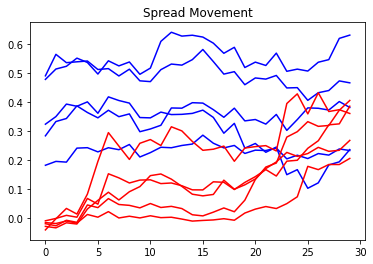

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ADA/USDT
ADF Test Value : -3.6856395074306367
Threshold : 1.1500000000000001
                    0         1
Total Trade  4.000000  3.000000
Avg PnL      0.040764 -0.048989
SL Rate      0.000000  0.333333


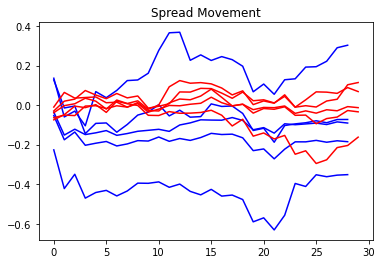

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BNB/USDT & ETH/USDT
ADF Test Value : -4.355875517831273
Threshold : 0.025
                    0         1
Total Trade  6.000000  5.000000
Avg PnL      0.052935  0.028002
SL Rate      0.000000  0.000000


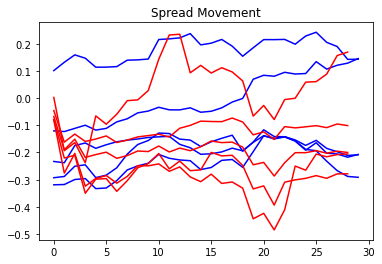

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : BTC/USDT & XRP/USDT
ADF Test Value : -2.239533150634762
Threshold : 0.675
                    0         1
Total Trade  5.000000  2.000000
Avg PnL      0.038037 -0.010347
SL Rate      0.000000  0.500000


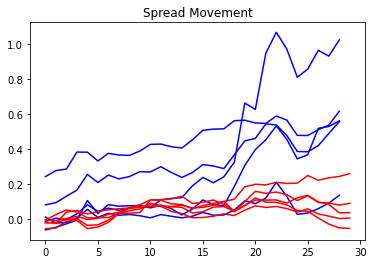

####Monthly Signal Performance####
Date : 2019-04
Selected Pair : XRP/USDT & ADA/USDT
ADF Test Value : -3.5042683234795016
Threshold : 1.125
                    0         1
Total Trade  4.000000  2.000000
Avg PnL      0.044416 -0.008003
SL Rate      0.000000  0.500000


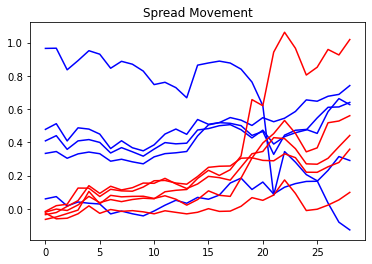

In [363]:
ADF_test_value_list = []
current_total_trade_list = []
prev_total_trade_list = []
current_Avg_PnL_list = []
prev_Avg_PnL_list = []
current_SL_Rate_list = []
prev_SL_Rate_list = []


for i in range(len(monthly_trade_info)):
    
    current_trade_info = monthly_trade_info[i]
    prev_trade_info = monthly_prev_trade_info[i]
    pair_info = monthly_pair_characteristic[i]
    
    Date = trade_info['trade date'][0][:-3]
    first_asset = pair_info['first_asset'][0]
    second_asset = pair_info['second_asset'][0]
    ADF_test_value = pair_info['ADF test value'][0]
    Threshold = monthly_threshold[i]
    current_spread = monthly_spread[i]
    prev_spread = monthly_prev_spread[i]
    current_total_trade = len(current_trade_info)
    prev_total_trade = len(prev_trade_info)
    current_Avg_PnL = np.mean([float(i) for i in current_trade_info['PnL']])
    prev_Avg_PnL = np.mean([float(i) for i in prev_trade_info['PnL']])
    current_SL_Rate = sum(current_trade_info['coverage']=='SL')/current_total_trade
    prev_SL_Rate = sum(prev_trade_info['coverage']=='SL')/prev_total_trade
    
    signal_performance_df = pd.DataFrame()
    signal_performance_df['Total Trade'] = [prev_total_trade , current_total_trade]
    signal_performance_df['Avg PnL'] = [prev_Avg_PnL , current_Avg_PnL]
    signal_performance_df['SL Rate'] = [prev_SL_Rate , current_SL_Rate]
    signal_performance_df = signal_performance_df.T
    
    print('####Monthly Signal Performance####')
    print('Date : %s' % Date)
    print('Selected Pair : %s & %s' %(first_asset , second_asset))
    print('ADF Test Value : %s' % ADF_test_value)
    print('Threshold : %s' % Threshold)
    
    print(signal_performance_df)
        
    plt.plot(np.array(current_spread) , color = 'b' ,label = 'current')
    plt.plot(np.array(prev_spread) , color = 'r' , label = 'previous')
    plt.title('Spread Movement')
    plt.show()
        
    ADF_test_value_list.append(ADF_test_value)
    current_total_trade_list.append(current_total_trade)
    prev_total_trade_list.append(prev_total_trade)
    current_Avg_PnL_list.append(current_Avg_PnL)
    prev_Avg_PnL_list.append(prev_Avg_PnL)
    current_SL_Rate_list.append(current_SL_Rate)
    prev_SL_Rate_list.append(prev_SL_Rate)
    
    
    

In [ ]:
print('Aggregated View')

plt.plot(ADF_test_value_list)
plt.title('ADF_test_value')
plt.show()

plt.plot(current_total_trade_list , color = 'b' ,label = 'current')
plt.plot(prev_total_trade_list , color = 'r' , label = 'previous')
plt.title('Total Trade')
plt.show()

plt.plot(current_Avg_PnL_list , color = 'b' ,label = 'current')
plt.plot(prev_Avg_PnL_list , color = 'r' , label = 'previous')
plt.title('Avg PnL')
plt.show()

plt.plot(current_SL_Rate , color = 'b' ,label = 'current')
plt.plot(prev_SL_Rate , color = 'r' , label = 'previous')
plt.title('SL Rate')
plt.show()